## **E1 213 Pattern Recognition and Neural Network Assignment - 03**

### **Group No. - 24**


## **Importing Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import zipfile
import tqdm
from tqdm import tqdm
import cv2
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from PIL import Image
import random
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from gensim.models import Word2Vec
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **General Tasks**

### **PCA**

In [ ]:
class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.eigenvectors = None
        self.mean = None
        self.explained_variance = None

    def fit(self, data):

        # Compute the mean of the data
        self.mean = np.mean(data, axis=0)

        # Center the data
        centered_data = data - self.mean

        # Compute the covariance matrix
        covariance_matrix = np.cov(centered_data, rowvar=False)

        # Compute the eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Sort the eigenvalues and corresponding eigenvectors
        sorted_index = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_index]
        sorted_eigenvectors = eigenvectors[:, sorted_index]

        # Select the first n eigenvectors
        self.eigenvectors = sorted_eigenvectors[:, :self.n_components]

        # Calculate the explained variance
        self.explained_variance = np.sum(sorted_eigenvalues[:self.n_components]) / np.sum(sorted_eigenvalues)

        print(f"Explained variance: {self.explained_variance * 100 : .3f}")

    def transform(self, data):
        # Center the data
        centered_data = data - self.mean

        # Transform the data
        data_reduced = np.dot(self.eigenvectors.transpose(), centered_data.transpose()).transpose()
        return data_reduced

    def plot_explained_variance_vs_n_components(self, data):
        explained_variance_ratios = []
        n_components_list = np.arange(0,1050,50)

        for i in n_components_list:
            pca = PCA(n_components = i)
            pca.fit(data)
            explained_variance_ratios.append(pca.explained_variance)

        plt.plot(n_components_list, explained_variance_ratios)
        plt.title('Explained Variance vs. Number of Components')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance')
        plt.grid(True)
        plt.show()

        return explained_variance_ratios

### **K - Means**

In [ ]:
class KMeans:

    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, distance_metric='euclidean'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.distance_metric = distance_metric

    def _calculate_distance(self, X, centroids):
        if self.distance_metric == 'euclidean':
            distances = np.linalg.norm(X - centroids[:, np.newaxis], axis=2)
        elif self.distance_metric == 'manhattan':
            distances = np.sum(np.abs(X - centroids[:, np.newaxis]), axis=2)
        else:
            raise ValueError("Invalid distance metric. Please choose 'euclidean' or 'manhattan'.")
        return distances

    def _assign_clusters(self, X, centroids):
        # Calculate distances between each data point and each centroid
        distances = self._calculate_distance(X, centroids)
        # Assign each data point to the cluster with the nearest centroid
        labels = np.argmin(distances, axis=0)
        return labels

    def _update_centroids(self, X, labels):
        centroids = np.empty((self.n_clusters, X.shape[1]))
        # Calculate the mean of the data points assigned to each cluster
        for i in range(self.n_clusters):
            centroids[i] = np.mean(X[labels == i], axis=0)
        return centroids

    def fit(self, X):
        # Initialize centroids randomly
        centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        prev_centroids = centroids.copy()
        for _ in range(self.max_iter):
            # Assign each data point to the nearest centroid
            labels = self._assign_clusters(X, centroids)
            # Update centroids based on the mean of the data points assigned to each cluster
            centroids = self._update_centroids(X, labels)
            # Check for convergence
            if np.linalg.norm(centroids - prev_centroids) < self.tol:
                break
            prev_centroids = centroids.copy()
        self.labels_ = labels
        self.cluster_centers_ = centroids
        return self.labels_

    def predict(self, X):

        labels_out = []
        for x_test in X:
            distances = self._calculate_distance(x_test, self.cluster_centers_)
            labels_new = np.argmin(distances, axis=0)
            labels_out.append(labels_new)

        return labels_out

In [ ]:
def calculate_nmi(labels_true, labels_pred):

    # Convert inputs to numpy arrays
    true_labels = np.asarray(labels_true)
    pred_labels = np.asarray(labels_pred)

    # Compute number of samples, true classes, and predicted clusters
    n_samples = true_labels.shape[0]
    n_true_classes = np.unique(true_labels).shape[0]
    n_pred_clusters = np.unique(pred_labels).shape[0]

    # Compute contingency matrix
    contingency_matrix = np.zeros((n_true_classes, n_pred_clusters))
    for i in range(n_samples):
        contingency_matrix[true_labels[i], pred_labels[i]] += 1

    # Compute marginal probabilities
    sum_contingency = np.sum(contingency_matrix)
    sum_rows = np.sum(contingency_matrix, axis=1)
    sum_cols = np.sum(contingency_matrix, axis=0)
    proba_true_class = sum_rows / sum_contingency
    proba_pred_cluster = sum_cols / sum_contingency

    # Compute mutual information
    mutual_information = 0.0
    eps = np.finfo(float).eps
    for i in range(n_true_classes):
        for j in range(n_pred_clusters):
            if contingency_matrix[i, j] != 0:
                numerator = contingency_matrix[i, j] * np.log((contingency_matrix[i, j] * sum_contingency) / (sum_rows[i] * sum_cols[j]) + eps)
                mutual_information += numerator
    mutual_information /= sum_contingency

    # Compute entropy
    entropy_true = -np.sum(proba_true_class * np.log(proba_true_class + eps))
    entropy_pred = -np.sum(proba_pred_cluster * np.log(proba_pred_cluster + eps))

    # Compute normalized mutual information
    denominator = (entropy_true + entropy_pred) / 2
    if denominator < eps:
        return 1.0
    else:
        return mutual_information / denominator

### **Decision Tree**

In [ ]:
class DecisionTree:
    def __init__(self, max_depth, criterion):

        self.max_depth = max_depth
        self.criterion = criterion

    def fit(self, features, labels):
        """
        Fit the decision tree to the training data.

        Args:
            features (ndarray): The training data, with shape (num_samples, num_features).
            labels (ndarray): The target values, with shape (num_samples,).
        """
        self.num_classes = 12
        self.tree = self._build_tree(features, labels, 0)

    def _build_tree(self, features, labels, depth):
        """
        Recursive method to build the decision tree.

        Args:
            features (ndarray): The data for the current node, with shape (num_samples, num_features).
            labels (ndarray): The target values for the current node, with shape (num_samples,).
            depth (int): The current depth of the tree.

        Returns:
            dict: A dictionary representing the current node.
        """
        num_samples, num_features = features.shape

        # Count the number of samples per class
        num_samples_per_class = [np.sum(labels == i) for i in range(self.num_classes)]

        # Get the class with the maximum count
        class_majority = np.argmax(num_samples_per_class)
        # class_majority = num_samples_per_class / np.sum(num_samples_per_class)

        # If the maximum depth has been reached or there is only one class left, make a leaf node
        if depth == self.max_depth or self.num_classes == 1:
            return {'leaf': True, 'class': class_majority}

        # If there are no samples, make a leaf node with the majority class
        if num_samples == 0:
            return {'leaf': True, 'class': class_majority}

        # If all samples have the same class, make a leaf node with that class
        if np.all(labels == labels[0]):
            return {'leaf': True, 'class': labels[0]}

        # Randomly select a subset of features to consider for splitting
        feature_indices = np.arange(num_features)
        np.random.shuffle(feature_indices)
        feature_indices = feature_indices[:int(np.sqrt(num_features))]

        # Initialize best feature index and threshold
        best_feature_index = None
        best_threshold = None

        if self.criterion == 'gini':
            # Initialize the best gini index to infinity
            best_gini = np.inf

            # Loop over the selected features and possible thresholds
            for feature_index in feature_indices:
                thresholds = np.unique(features[:, feature_index])
                for threshold in thresholds:
                    left_indices = features[:, feature_index] <= threshold
                    right_indices = features[:, feature_index] > threshold

                    num_samples_left = len(labels[left_indices])
                    num_samples_right = len(labels[right_indices])

                    # If either split has no samples, skip this threshold
                    if num_samples_left == 0 or num_samples_right == 0:
                        continue

                    # Calculate the gini index for the left and right splits
                    gini_left = 1 - sum((np.sum(labels[left_indices] == c) / num_samples_left) ** 2 for c in range(self.num_classes))
                    gini_right = 1 - sum((np.sum(labels[right_indices] == c) / num_samples_right) ** 2 for c in range(self.num_classes))
                    weighted_gini = (num_samples_left / num_samples) * gini_left + (num_samples_right / num_samples) * gini_right

                    if weighted_gini < best_gini:
                        best_gini = weighted_gini
                        best_feature_index = feature_index
                        best_threshold = threshold

        elif self.criterion == 'entropy':
            best_entropy = np.inf

            for feature_index in feature_indices:
                thresholds = np.unique(features[:, feature_index])
                for threshold in thresholds:
                    left_indices = features[:, feature_index] <= threshold
                    right_indices = features[:, feature_index] > threshold

                    num_samples_left = len(labels[left_indices])
                    num_samples_right = len(labels[right_indices])

                    if num_samples_left == 0 or num_samples_right == 0:
                        continue

                    entropy_left = -sum((np.sum(labels[left_indices] == c) / num_samples_left) * np.log2((np.sum(labels[left_indices] == c) / num_samples_left) + 1e-10) for c in range(self.num_classes))
                    entropy_right = -sum((np.sum(labels[right_indices] == c) / num_samples_right) * np.log2((np.sum(labels[right_indices] == c) / num_samples_right) + 1e-10) for c in range(self.num_classes))
                    weighted_entropy = (num_samples_left / num_samples) * entropy_left + (num_samples_right / num_samples) * entropy_right

                    if weighted_entropy < best_entropy:
                        best_entropy = weighted_entropy
                        best_feature_index = feature_index
                        best_threshold = threshold


        # Check if best_feature_index and best_threshold are still None
        if best_feature_index is None or best_threshold is None:
            # Handle case where no valid split is found
            # You can return a leaf node here or handle it in another appropriate way
            return {'leaf': True, 'class': class_majority}

        # Split data based on best feature and threshold
        left_indices = features[:, best_feature_index] <= best_threshold
        right_indices = features[:, best_feature_index] > best_threshold

        # Continue with building the tree
        left_subtree = self._build_tree(features[left_indices], labels[left_indices], depth + 1)
        right_subtree = self._build_tree(features[right_indices], labels[right_indices], depth + 1)

        return {'leaf': False,
                'feature_index': best_feature_index,
                'threshold': best_threshold,
                'left_subtree': left_subtree,
                'right_subtree': right_subtree}

    def predict(self, features):
        # For each row of features x in features, traverse the decision tree to predict the class label
        return np.array([self._traverse_tree(x, self.tree) for x in features])

    # This is a recursive helper function that traverses the decision tree to predict the class label for a single row of features x
    def _traverse_tree(self, x, node):
        # If the current node is a leaf node, return the predicted class label
        if node['leaf']:
            return node['class']
        # If the current node is not a leaf node, determine whether to traverse the left or right subtree based on the feature value
        if x[node['feature_index']] <= node['threshold']:
            return self._traverse_tree(x, node['left_subtree'])
        else:
            return self._traverse_tree(x, node['right_subtree'])


### **Random Forest**

In [ ]:
class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees = 25, max_depth = 5, criterion = 'gini'):

        self.num_trees = num_trees
        self.max_depth = max_depth
        self.criterion = criterion

        # Will store individually trained decision trees
        self.decision_trees = []


    def _sample(self, features, labels):
        '''
        Helper function used for bootstrap sampling.

        :param features: np.array, features
        :param labels: np.array, target
        :return: tuple (sample of features, sample of target)
        '''
        n_samples, n_features = features.shape

        sample_size = 0.33

        # Sample with replacement
        samples = np.random.choice(a = n_samples, size=int(n_samples*sample_size), replace=True)
        return features[samples], labels[samples]

    def fit(self, features, labels):
        '''
        Trains a Random Forest classifier.

        :param features: np.array, features
        :param labels: np.array, target
        :return: None
        '''

        # Build each tree of the forest
        for num_built in range(self.num_trees):

            tree = DecisionTree(
                max_depth = self.max_depth,
                criterion = self.criterion
            )
            # Obtain data sample
            _features, _labels = self._sample(features, labels)

            # Train
            tree.fit(_features, _labels)

            # Save the classifier
            self.decision_trees.append(tree)

            print(f'Tree {num_built+1} fitted!')


    def predict(self, features):
        '''
        Predicts class labels for new data instances.

        :param features: np.array, new instances to predict
        :return: predictions
        '''

        # Make predictions with every tree in the forest
        predictions = []
        for tree in self.decision_trees:
            predictions.append(tree.predict(features))

        # Reshape so we can find the most common value
        predictions = np.swapaxes(a = predictions, axis1 = 0, axis2 = 1)

        # Use majority voting for the final prediction
        final_predictions = []
        for preds in predictions:
            label_counts = {}
            for label in preds:
                if label not in label_counts:
                    label_counts[label] = 1
                else:
                    label_counts[label] += 1
            max_count = 0
            max_label = None
            for label, count in label_counts.items():
                if count > max_count:
                    max_count = count
                    max_label = label
            final_predictions.append(max_label)
        return np.array(final_predictions)

### **Deep Model**

#### **Performance Metrics**

In [ ]:
# Performance Metrics

# Classification Accuracy
def accuracy(actual_y, pred_y):

    if len(pred_y.shape)==3:
        pred_y = pred_y[:,:,0]

    if len(actual_y.shape)==3:
        actual_y = actual_y[:,:,0]

    if len(pred_y.shape)>1:
        if pred_y.shape[1]>1:
            pred_y = np.argmax(pred_y,axis=1)

    if len(actual_y.shape)>1:
        if actual_y.shape[1]>1:
            actual_y = np.argmax(actual_y,axis=1)

    return np.sum(actual_y == pred_y) / actual_y.shape[0]

# Confusion Matrix
def confusion_matrix(actual_y, pred_y):

    if len(pred_y.shape)==3:
        pred_y = pred_y[:,:,0]

    if len(actual_y.shape)==3:
        actual_y = actual_y[:,:,0]

    if len(pred_y.shape)>1:
        if pred_y.shape[1]>1:
            pred_y = np.argmax(pred_y,axis=1)

    if len(actual_y.shape)>1:
        if actual_y.shape[1]>1:
            actual_y = np.argmax(actual_y,axis=1)

    # Get the unique labels
    unique_labels = np.unique(np.concatenate((actual_y, pred_y)))

    # Initialize the confusion matrix with zeros
    confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)))

    # Fill the confusion matrix
    for i in range(len(actual_y)):
        actual_label = actual_y[i]
        pred_label = pred_y[i]
        confusion_matrix[unique_labels == actual_label, unique_labels == pred_label] += 1

    return confusion_matrix

# Plotting Confusion Matrix
def confusion_matrix_heatmap(cm, title="Confusion Matrix"):

  # Get the number of classes
  num_classes = np.shape(cm)[0]

  # Make the cm into probability_cm
  row_sums = cm.sum(axis=1, keepdims=True)  # Calculate the row sums

  # Normalize by row sums to get probabilities
  probability_cm = cm / row_sums

  # Create the heatmap
  plt.imshow(probability_cm, cmap="Blues")  # Choose a colormap
  plt.colorbar()

  for i in range(num_classes):
    for j in range(num_classes):
        # Format the text to display two decimal places
        text = f"{probability_cm[i, j]:.2f}"
        plt.text(j, i, text, ha="center", va="center", fontsize=10, color="black", alpha = 0.6)  # Adjust fontsize and color as needed

  # Add labels and title
  plt.xticks(ticks = np.arange(num_classes), labels = np.arange(0, num_classes))
  plt.yticks(ticks = np.arange(num_classes), labels = np.arange(0, num_classes))
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.title(title)

  # Show the plot
  plt.show()

def f1_score(actual_y, pred_y):

    if len(pred_y.shape)==3:
        pred_y = pred_y[:,:,0]

    if len(actual_y.shape)==3:
        actual_y = actual_y[:,:,0]

    if len(pred_y.shape)>1:
        if pred_y.shape[1]>1:
            pred_y = np.argmax(pred_y,axis=1)

    if len(actual_y.shape)>1:
        if actual_y.shape[1]>1:
            actual_y = np.argmax(actual_y,axis=1)

    # Multi-class classification: calculate F1 score for each class and average
    f1_scores = []
    for class_label in np.unique(actual_y):
        TP = np.sum((actual_y == class_label) & (pred_y == class_label))
        FP = np.sum((actual_y != class_label) & (pred_y == class_label))
        FN = np.sum((actual_y == class_label) & (pred_y != class_label))
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1_score)
    return np.mean(f1_scores)

def roc_curve_pair(actual_y, pred_y, class_0, class_1):
    """
    Calculates the ROC curve for a specific pair of classes in a multi-class problem.

    Args:
        actual_y: A numpy array of the actual labels.
        pred_y: A numpy array of the predicted probabilities for each class.
        class_0: The label of the first class in the pair.
        class_1: The label of the second class in the pair.

    Returns:
        A tuple of (fpr, tpr, thresholds):
            fpr: False positive rate
            tpr: True positive rate
            thresholds: Decision thresholds used to compute fpr and tpr
    """

    # Filter data for the chosen classes
    y_true = actual_y[((actual_y == class_0) | (actual_y == class_1))]
    y_score = pred_y[((actual_y == class_0) | (actual_y == class_1)), class_1]  # Probabilities for class_1

    # Get unique thresholds for ROC curve calculation
    thresholds = np.unique(np.sort(y_score))

    # Initialize fpr and tpr with 0s
    fpr = np.zeros_like(thresholds)
    tpr = np.zeros_like(thresholds)

    # Calculate TPR and FPR for each threshold
    for i, thresh in enumerate(thresholds):
        y_pred = (y_score >= thresh).astype(int)
        tp = np.sum(y_pred[y_true == class_1])
        fp = np.sum(y_pred[y_true == class_0])
        fn = np.sum((1 - y_pred)[y_true == class_1])
        tn = np.sum((1 - y_pred)[y_true == class_0])
        tpr[i] = tp / (tp + fn)
        fpr[i] = fp / (fp + tn)

    return fpr, tpr, thresholds

def plot_ROC(actual_y,pred_y,class_0,class_1):

    # Get ROC curve for classes 0 and 1
    fpr, tpr, thresholds = roc_curve_pair(actual_y, pred_y, class_0=class_0, class_1=class_1)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label='ROC curve')

    # Plot the line of no discrimination (random guessing)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Discrimination')

    # Set axis labels and title
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC between Class:{class_0} and Class:{class_1}')

    # Add legend
    plt.legend()

    # Display plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def categorical_crossentropy_loss(y_true, y_pred):
    num_samples = len(y_true)
    loss = -np.sum(np.log(y_pred[np.arange(num_samples), y_true])) / num_samples
    return loss

#### **Pre-trained Model**

In [ ]:
# import tensorflow
# from tensorflow import keras
# from keras.applications.vgg16 import VGG16
# from keras.models import Model

# img_width, img_height = 224, 224
# model = keras.applications.VGG16(weights='imagenet', include_top=True, input_shape=(img_width, img_height, 3))

# layer_name = 'fc2'
# model= Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
# model.summary()

#### **Layers**

In [ ]:
class Layer:

    def __init__(self, name, input_size, output_size, params=None):

        self.name = name
        self.input_size = input_size
        self.output_size = output_size
        self.params = params  # Trainable parameters (if applicable)

        # Calculate number of trainable parameters for convolutional layers
        if isinstance(self, Conv):
            self.num_params = (self.kernel_size**2) * self.num_filters

        if isinstance(self, Dense):
            self.num_params = np.size(self.weights) + np.size(self.biases)

        if isinstance(self, Dense_Softmax):
            self.num_params = np.size(self.weights) + np.size(self.biases)

    def __str__(self):
        param_str = f"({self.num_params:,})" if self.params is not None else " -"

        return f" {self.name:^20} | {str(self.input_size):^20} -> {str(self.output_size):^20} | {param_str:^20} "

    def forward(self, input):
        # return output
        pass

    def backprop(self, output_gradient, learning_rate):
        # update parameters and return input gradient
        pass

In [ ]:
# Conv2D Layer

class Conv(Layer):

    def __init__(self, input_shape, num_filters, kernel_size, stride, padding='valid'):

        self.name = "Conv"

        self.input_shape = input_shape

        h, w, c = input_shape

        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        if self.padding == 'valid':
            # No padding, output size will reduce
            self.h_out = (h - self.kernel_size) // self.stride + 1
            self.w_out = (w - self.kernel_size) // self.stride + 1
            self.pad = 0

        elif self.padding == 'same':
            # Same padding, output size same as input
            self.h_out = h // self.stride
            self.w_out = w // self.stride
            self.pad = (self.kernel_size - 1) // 2

        self.filters = np.random.randn(self.num_filters, self.kernel_size, self.kernel_size, c) / self.kernel_size**2

        self.output_shape = (self.h_out,self.w_out,self.num_filters)

        super().__init__("Conv2D", self.input_shape, self.output_shape, params=(self.filters))


    def iterate_regions(self, image):

        # generates all possible kernel_size * kernel_size image regions using padding and stride

        h, w, c = image.shape

        if self.padding == 'valid':
            # No padding, output size will reduce
            self.h_out = (h - self.kernel_size) // self.stride + 1
            self.w_out = (w - self.kernel_size) // self.stride + 1

        elif self.padding == 'same':
            # Same padding, output size same as input
            self.h_out = h // self.stride
            self.w_out = w // self.stride

        for i in range(0, self.h_out, self.stride):
            for j in range(0, self.w_out, self.stride):

                if self.padding == 'valid' or (i + self.kernel_size <= h and j + self.kernel_size <= w):
                    im_region = image[i:i+self.kernel_size, j:j+self.kernel_size]

                else:
                    # Padding
                    pad_top = max(0, self.kernel_size - h + i)
                    pad_bottom = max(0, self.kernel_size - (h - i))
                    pad_left = max(0, self.kernel_size - w + j)
                    pad_right = max(0, self.kernel_size - (w - j))
                    im_region = np.pad(image[i:i+self.kernel_size, j:j+self.kernel_size],
                                       ((pad_top, pad_bottom), (pad_left, pad_right)),
                                       mode='constant', constant_values=0)
                yield im_region, i, j

    def forward(self, input):

        self.last_input = input
        height, width, _ = input.shape

        output = np.zeros((self.h_out, self.w_out, self.num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2, 3))

        return output

    def backprop(self, d_l_d_out, learn_rate, reg_type, reg_strength):

        '''
        Performs a backward pass of the conv layer.
        - d_l_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''

        d_l_d_filters = np.zeros(self.filters.shape)
        d_l_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):

            for f in range(self.num_filters):

                d_l_d_filters[f] += d_l_d_out[i, j, f] * im_region

        # Regularization
        if reg_type:
            if reg_type == 'l2':
                d_l_d_filters += reg_strength * self.filters
            elif reg_type == 'l1':
                d_l_d_filters += reg_strength * np.sign(self.filters)

        # update filters
        self.filters -= learn_rate * d_l_d_filters

        return d_l_d_input

In [ ]:
# # Example usage
# input_image = np.random.randn(28, 28, 1)  # Example input image
# conv_layer = Conv(input_shape = (28,28,1), num_filters = 32, kernel_size = 3, padding = 'valid', stride = 1)
# print(conv_layer.filters.shape)
# output = conv_layer.forward(input_image)
# print(output.shape)  # Should output (1, 1, 8)
# d_l_d_out = np.random.randn(26, 26, 32)
# sent_grad = conv_layer.backprop(d_l_d_out, learn_rate=0.01, reg_type=None, reg_strength=0)
# print(sent_grad.shape)

In [ ]:
class MaxPool2(Layer):
  # A Max Pooling layer using a pool size of 2.

  def __init__(self, input_shape):

    self.input_shape = input_shape

    h, w, _ = input_shape
    new_h = h // 2
    new_w = w // 2

    self.output_shape = (new_h,new_w,_)

    super().__init__("MaxPool2", self.input_shape, self.output_shape, params=None)

  def iterate_regions(self, image):
    '''
    Generates non-overlapping 2x2 image regions to pool over.
    - image is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        # Extract a region from the input tensor to apply max pooling on
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        # Yield the region along with its position
        yield im_region, i, j

  def forward(self, input):
    '''
    Performs a forward pass of the maxpool layer using the given input.
    Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
    - input is a 3d numpy array with dimensions (h, w, num_filters)
    '''
    # Remember the input for backpropagation
    self.last_input = input

    h, w, num_filters = input.shape
    # Initialize the output tensor with zeros
    output = np.zeros((h // 2, w // 2, num_filters))

    # Iterate over non-overlapping 2x2 regions and perform max pooling on each region
    for im_region, i, j in self.iterate_regions(input):
      # Calculate the maximum value in the region across all channels
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out, learn_rate, reg_type, reg_strength):
    '''
    Performs a backward pass of the maxpool layer.
    Returns the loss gradient for this layer's inputs.
    - d_L_d_out is the loss gradient for this layer's outputs.
    '''
    # Initialize the input gradient tensor with zeros
    d_L_d_input = np.zeros(self.last_input.shape)

    # Iterate over the same non-overlapping 2x2 regions as in the forward pass
    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      # Find the indices of the maximum values in the region across all channels
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              # Distribute the gradient equally to all maximum pixels in the region
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

In [ ]:
# Dense Layer

class Dense(Layer):

    def __init__(self, input_len, nodes):

        self.name = "Dense"
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)
        self.input_shape = input_len
        self.output_shape = nodes

        super().__init__("Dense", self.input_shape, self.output_shape, params=(self.weights, self.biases))

    def forward(self, input):

        self.last_input_shape = input.shape

        input = input.flatten()

        self.last_input = input

        totals = np.dot(input, self.weights) + self.biases

        return totals

    def backprop(self, d_l_d_out, learn_rate, reg_type, reg_strength):

        d_l_d_inputs = np.dot(d_l_d_out, self.weights.T)
        d_l_d_weights = np.dot(self.last_input.reshape(-1, 1), d_l_d_out.reshape(1, -1))
        d_l_d_biases = d_l_d_out

        # Regularization Gradient
        reg_grad = 0
        if reg_type:
            if reg_type == 'l1':
                reg_grad = reg_strength * np.sign(self.weights)
            elif reg_type == 'l2':
                reg_grad = reg_strength * self.weights
            elif reg_type == 'elastic_net':
                l1_ratio = 0.5
                l1_grad = l1_ratio * np.sign(self.weights)
                l2_grad = (1 - l1_ratio) * self.weights
                reg_grad = reg_strength * (l1_grad + l2_grad)

        self.weights -= learn_rate * (d_l_d_weights + reg_grad)

        self.biases -= learn_rate * d_l_d_biases

        return d_l_d_inputs.reshape(self.last_input_shape)


In [ ]:
# Dense with Softmax

class Dense_Softmax(Layer):

    def __init__(self, input_len, nodes):

        self.name = "Dense_Softmax"

        # We divide by input_len to reduce the variance of our initial values
        self.weights = np.random.randn(input_len, nodes)/input_len
        self.biases = np.zeros(nodes)

        self.input_shape = input_len
        self.output_shape = nodes

        super().__init__("Dense_softmax", self.input_shape, self.output_shape, params=(self.weights, self.biases))

    def forward(self, input):

        self.last_input_shape = input.shape

        input = input.flatten()
        self.last_input = input

        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals)
        return(exp/np.sum(exp, axis=0))

    def backprop(self, d_l_d_out, learn_rate, reg_type, reg_strength):

        """
        Performs a backward pass of the softmax layer.
        Returns the loss gradient for this layers inputs.
        - d_L_d_out is the loss gradient for this layers outputs.
        """

        #We know only 1 element of d_l_d_out will be nonzero
        for i, gradient in enumerate(d_l_d_out):
            if(gradient == 0):
                continue

            #e^totals
            t_exp = np.exp(self.last_totals)

            #Sum of all e^totals
            S = np.sum(t_exp)

            #gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp/ (S**2)
            d_out_d_t[i] = t_exp[i] * (S-t_exp[i]) /(S**2)

            # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            #Gradients of loss against totals
            d_l_d_t = gradient * d_out_d_t

            #Gradients of loss against weights/biases/input
            d_l_d_w = d_t_d_w[np.newaxis].T @ d_l_d_t[np.newaxis]
            d_l_d_b = d_l_d_t * d_t_d_b
            d_l_d_inputs = d_t_d_inputs @ d_l_d_t

            # Regularization
            if reg_type == 'l2':
                d_l_d_w += reg_strength * self.weights
            elif reg_type == 'l1':
                d_l_d_w += reg_strength * np.sign(self.weights)
            elif reg_type == 'elastic_net':
                l1_ratio = 0.5
                d_l_d_w += reg_strength * ((1-l1_ratio) * self.weights + l1_ratio * np.sign(self.weights))

            #update weights/biases
            self.weights -= learn_rate * d_l_d_w
            self.biases -= learn_rate * d_l_d_b

            return d_l_d_inputs.reshape(self.last_input_shape)

In [ ]:
class Sigmoid(Layer):

    def __init__(self):
        self.name = "Sigmoid"
        self.input_shape = None
        self.output_shape = None

        super().__init__("Sigmoid",None,None)

    def forward(self, input):
        self.last_input = input
        return 1 / (1 + np.exp(-input))

    def backprop(self, d_out, learn_rate, reg_type, reg_strength):
        sig = self.forward(self.last_input)
        return d_out * sig * (1 - sig)


class ReLU(Layer):

    def __init__(self):
        self.name = "ReLU"
        self.input_shape = None
        self.output_shape = None
        super().__init__("ReLU",None,None)


    def forward(self, input):
        self.last_input = input
        return np.maximum(0, input)

    def backprop(self, d_out, learn_rate, reg_type, reg_strength):
        d_input = d_out.copy()
        d_input[self.last_input <= 0] = 0
        return d_input

class LeakyReLU(Layer):
    def __init__(self, alpha=0.2):
        self.name = "LeakyReLU"
        self.alpha = alpha
        self.input_shape = None
        self.output_shape = None
        super().__init__("LeakyReLU",None,None)

    def forward(self, input):
        self.last_input = input
        return np.where(input > 0, input, input * self.alpha)

    def backprop(self, d_out, learn_rate, reg_type, reg_strength):
        return np.where(self.last_input > 0, d_out, d_out * self.alpha)

#### **Model Class**

In [ ]:
# The Main Model

class Model:

    def __init__(self, network):

        self.network = network
        if len(network)>0:
            self.n_classes = self.network[-1].output_shape

    def forward(self, input, label, loss_type = 'cross_entropy'):

        out = input

        for layer in self.network:
            out = layer.forward(out)

        if loss_type == 'cross_entropy':
            loss = self.cross_entropy_loss(out,label)

        elif loss_type == 'mse':
            loss = self.mse_loss(out,label)

        acc = 1 if (np.argmax(out) == label) else 0

        return out, loss, acc

    def predict(self, X):

        pred_y = []

        for x in X:
            out = x
            for layer in self.network:
                out = layer.forward(out)
            pred_y.append(out)

        pred_y = np.array(pred_y)

        return pred_y

    def train(self, input, label, lr, reg_type, reg_strength = 0, loss_type='cross_entropy'):

        out, loss, acc = self.forward(input, label, loss_type = loss_type)

        if loss_type == 'cross_entropy':

            gradient = np.zeros(self.n_classes)
            gradient[label] = -1 / out[label]

        elif loss_type == 'mse':
            label_one_hot = np.zeros_like(out)
            label_one_hot[label] = 1
            gradient = 2 * (out - label_one_hot)

        # Regularization
        if reg_type:
            if reg_type == 'l2':
                reg_loss = 0
                for layer in self.network:
                    if hasattr(layer, 'weights'):
                        reg_loss += 0.5 * reg_strength * np.sum(layer.weights ** 2)
                loss += reg_loss

            elif reg_type == 'l1':
                reg_loss = 0
                for layer in self.network:
                    if hasattr(layer, 'weights'):
                        reg_loss += reg_strength * np.sum(np.abs(layer.weights))
                loss += reg_loss

            elif reg_type == 'elastic_net':
                l1_loss = 0
                l2_loss = 0
                l1_ratio = 0.5
                for layer in self.network:
                    if hasattr(layer, 'weights'):
                        l1_loss += reg_strength * l1_ratio * np.sum(np.abs(layer.weights))
                        l2_loss += 0.5 * reg_strength * (1 - l1_ratio) * np.sum(layer.weights ** 2)
                loss += l1_loss + l2_loss


        for layer in reversed(self.network):
            gradient = layer.backprop(gradient, lr, reg_type, reg_strength)

        return loss, acc

    def cross_entropy_loss(self, output, label):
        return -np.log(output[label])

    def mse_loss(self, output, label):
        y_true = np.zeros_like(output)
        y_true[label] = 1
        return np.sum((output - y_true) ** 2)

    def accuracy(actual_y, pred_y):

        if len(pred_y.shape)==3:
            pred_y = pred_y[:,:,0]

        if len(actual_y.shape)==3:
            actual_y = actual_y[:,:,0]

        if len(pred_y.shape)>1:
            if pred_y.shape[1]>1:
                pred_y = np.argmax(pred_y,axis=1)

        if len(actual_y.shape)>1:
            if actual_y.shape[1]>1:
                actual_y = np.argmax(actual_y,axis=1)

        return np.sum(actual_y == pred_y) / actual_y.shape[0]

    def fit(self, X_train, y_train, validation_data = None, batch_size = 32, epochs=3, learning_rate = 0.005, loss_type='cross_entropy', reg_type = None, reg_strength = 0, verbose = True):

        self.X_train = X_train
        self.y_train = y_train

        if validation_data:
            self.validation_x = validation_data[0]
            self.validation_y = validation_data[1]
            self.Validation_loss_list = []

        self.Training_loss_list = []

        for epoch in range(epochs):

            permutation = np.random.permutation(len(self.X_train))
            X_train = self.X_train[permutation]
            y_train = self.y_train[permutation]

            # Loss Initialization
            loss = 0
            num_correct = 0
            val_loss = 0

            for i, (im, label) in enumerate(zip(X_train, y_train)):

                l, acc = self.train(im, label, reg_type = reg_type, reg_strength=reg_strength, lr =  learning_rate , loss_type = loss_type)
                loss += l
                num_correct += acc

                # After each batch
                if (i > 0 and (i + 1) % batch_size == 0):

                    # Training Loss
                    train_loss = loss / batch_size
                    train_acc = num_correct / batch_size

                    num_correct = 0
                    loss = 0

                    # Printing Important metrics
                    if verbose:
                        print(f'\rEpoch : {epoch + 1} Batch : {i//batch_size}/{len(X_train) // batch_size} Training Loss {train_loss :.3f} | Training Accuracy: {train_acc * 100 :.2f}%', end="")

            # Print Last Values after end of One Epoch

            # Validation Metrics
            val_loss = 0
            val_acc = 0
            if validation_data:
                y_pred = []
                for image,y_label in zip(self.validation_x,self.validation_y):
                    out_im,val_loss_i,val_acc_i = self.forward(image,y_label, loss_type = loss_type)
                    val_loss += val_loss_i
                    val_acc+=val_acc_i
                    y_pred.append(out_im)
                y_pred = np.array(y_pred)
                # val_acc = self.accuracy(self.validation_y, y_pred)
                val_loss = val_loss / self.validation_y.shape[0]
                val_acc = val_acc / self.validation_y.shape[0]
                self.Validation_loss_list.append(val_loss)

            # Store Training loss
            self.Training_loss_list.append(train_loss)

            if verbose:
                if validation_data:
                    print(f'\rEpoch : {epoch + 1} Batch : {i//batch_size}/{len(X_train) // batch_size} Training Loss {train_loss :.3f} | Training Accuracy: {train_acc * 100 :.2f}% | Validation Loss {val_loss:.3f} | Validation Accuracy : {val_acc * 100:.2f}%')
                else:
                    print(f'\rEpoch : {epoch + 1} Batch : {i//batch_size}/{len(X_train) // batch_size} Training Loss {train_loss :.3f} | Training Accuracy: {train_acc * 100 :.2f}%')

            # print(f'\rEpoch : {epoch + 1} Batch : {i//batch_size}/{len(X_train) // batch_size} Training Loss {train_loss :.3f} | Training Accuracy: {train_acc * 100 :.2f}% | Validation Loss {val_loss:.3f} | Validation Accuracy : {val_acc * 100:.2f}%')

    def summary(self):

        print("Layer (name)          | Input Shape           | Output Shape         | Trainable Parameters")
        print("-------------------------------------------------------------------------------------------")
        total_params = 0
        for layer in self.network:
            print(layer)
            if layer.params is not None:
                for param in layer.params:
                    total_params += np.size(param)
        print("-------------------------------------------------------------------------------------------")
        print(f"Total Trainable Parameters: {total_params:,}")

    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(filename):
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        return model

### **AdaBoost**

In [ ]:
class Adaboost:

    def __init__(self, num_classifiers=5, classifier_type = 'MLP'):

        self.num_classifiers = num_classifiers
        self.classifiers = []
        self.losses = []
        self.accuracies = []
        self.ensemble_accuracies = []
        self.classifier_type = classifier_type

    def fit(self, features, labels):

        num_samples = features.shape[0]
        k = np.log(9)

        # Initialize weights to 1/N
        weights = np.ones(num_samples) / num_samples

        self.classifiers = []
        self.alphas = []

        # Iterate through classifiers
        for _ in range(self.num_classifiers):

            indices = np.random.choice(np.arange(num_samples), size=num_samples, replace=True, p = weights)
            X = features[indices]
            y = labels[indices]

            if self.classifier_type == "Decision Tree":

                clf = DecisionTree(max_depth=5, criterion='gini')
                clf.fit(X, y)
                y_pred = clf.predict(features)

            elif self.classifier_type == 'MLP':

                MLP_network  = [
                    Dense(20, 256),
                    LeakyReLU(),
                    Dense(256, 64),
                    LeakyReLU(),
                    Dense(64, 10)
                ]

                clf = Model(MLP_network)

                clf.fit(X, y, epochs=5, batch_size=32, learning_rate=0.01, loss_type='mse', verbose=False)

                y_pred = np.argmax(clf.predict(features), axis=1)

            elif self.classifier_type == 'CNN':

                CNN_network  = [
                    Conv(input_shape=(64, 64, 1), num_filters=8, kernel_size=3, padding='valid', stride=3),
                    LeakyReLU(),
                    Dense_Softmax(21*21*8, 10)
                ]

                clf = Model(CNN_network)

                clf.fit(X, y, epochs=5, batch_size=32, learning_rate=0.01, loss_type='cross_entropy', verbose=False)

                y_pred = np.argmax(clf.predict(features), axis=1)

            else:
                raise Exception("Classifier Type Not Supported!")
                break

            error = np.sum(weights[labels != y_pred])

            # calculate alpha
            EPS = 1e-10
            alpha = np.log((1.0 - error + EPS) / (error + EPS)) + k

            # calculate predictions and update weights
            z = (labels == y_pred)*1

            weights *= np.exp(-alpha * z)

            # Normalize to one
            weights /= np.sum(weights)

            y_pred_ensemble = self.predict(features)

            # Save classifier
            self.classifiers.append(clf)
            self.alphas.append(alpha)
            self.compute_exp_loss(features, labels)
            self.accuracies.append(np.mean(y_pred == labels))
            self.ensemble_accuracies.append(np.mean(y_pred_ensemble == labels))
            print("Learner: ", len(self.classifiers))
            print("Alpha: ", alpha)
            print("Accuracy of current classifier: ", self.accuracies[-1])
            print("Exp Loss: ", self.losses[-1])
            print("Accuracy of Ensemble classifier till now: ", self.ensemble_accuracies[-1])

    def compute_exp_loss(self, features, labels):
        y_pred = self.predict(features)
        z = (labels == y_pred)*2 - 1
        self.losses.append(np.mean(np.exp(-z)))

    def predict(self, features):
        y_pred = np.zeros(len(features))
        predictions = np.zeros((len(features), 10))
        for i in range(10):
            temp = np.zeros(len(features))
            for j in range(len(self.classifiers)):
                y = self.classifiers[j].predict(features)
                if self.classifier_type != 'Decision Tree':
                    y = np.argmax(self.classifiers[j].predict(features), axis=1)
                I = (y == i)
                temp +=  self.alphas[j]*I
            predictions[:, i] = temp

            y_pred = np.argmax(predictions, axis=1)
        return y_pred

    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load_model(filename):
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        return model

### **XGBoost**

In [ ]:
class XGBoost:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, criterion='gini'):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.criterion = criterion
        self.models = []

    def fit(self, X, y):

        y_pred = np.zeros_like(y, dtype=float)

        for _ in range(self.n_estimators):
            residual = y - y_pred
            tree = DecisionTree(max_depth=self.max_depth, criterion=self.criterion)
            tree.fit(X, residual)
            y_pred += self.learning_rate * tree.predict(X)
            self.models.append(tree)
            print(f'Learners fit {_+1}')

    def predict(self, X):
        y_pred = np.zeros(len(X))

        for tree in self.models:
            y_pred += self.learning_rate * tree.predict(X)

        return np.clip(np.round(y_pred),0,11)


## **Vision Dataset**

### **Loading Vision Data**

In [ ]:
def load_dataset(directory, image_size=(96, 96), color = 'gray', min_label_count = 1446, normalize = True):
    data = []
    labels = []
    label_mapping = {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
    label_count = {'cane': 0, 'cavallo': 0, 'elefante': 0, 'farfalla': 0, 'gallina': 0, 'gatto': 0, 'mucca': 0, 'pecora': 0, 'ragno': 0, 'scoiattolo': 0}
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(root, file)
                label = os.path.basename(os.path.normpath(root))
                if label in label_mapping:
                    if  label_count[label]<min_label_count:

                        image = cv2.imread(image_path)

                        if color == 'gray':
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        else:
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                        image = cv2.resize(image, image_size)
                        data.append(image)
                        labels.append(label_mapping[label])
                        label_count[label]+=1

    # Normalize
    if normalize:
        data = np.array(data, dtype=np.float32) / 255.0 - 0.5
    else:
        data = np.array(data, dtype=np.float32) / 255.0

    labels = np.array(labels)

    return data, labels

#### Grayscale Dataset

In [ ]:
zip_file_path = '/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/archive.zip'

# Create a directory to extract the files
extract_dir = '/content/dataset'
os.makedirs(extract_dir, exist_ok=True)

# Extract files from the ZIP archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for member in tqdm(zip_ref.infolist(), desc='Extracting files'):
        zip_ref.extract(member, extract_dir)

# Load the dataset
data_dir = '/content/dataset'
data, labels = load_dataset(data_dir, image_size=(64, 64))

# Shuffle the data and labels together
rng = np.random.RandomState(42)  # Set a (os, numpy, PIL, and tqdm) random seed for reproducibility
permutation = rng.permutation(len(data))
data = data[permutation]
labels = labels[permutation]

# Calculate the split indices
num_samples = len(data)
train_ratio = 0.6
validation_ratio = 0.1
train_size = int(num_samples * train_ratio)
train_validation_size = int(num_samples * (train_ratio + validation_ratio))
test_size = num_samples - train_validation_size

# Split the data into train and test and validation sets
x_train_vision, x_validation_vision, x_test_vision = data[:train_size], data[train_size:train_validation_size], data[train_validation_size:]
y_train_vision, y_validation_vision, y_test_vision = labels[:train_size], labels[train_size:train_validation_size], labels[train_validation_size:]

print("Shape of x_train: ", x_train_vision.shape)
print("Shape of y_train: ", y_train_vision.shape)
print("Shape of x_validation: ", x_validation_vision.shape)
print("Shape of y_validation: ", y_validation_vision.shape)
print("Shape of x_test: ", x_test_vision.shape)
print("Shape of y_test: ", y_test_vision.shape)

Extracting files: 100%|██████████| 26180/26180 [00:30<00:00, 858.89it/s] 


Shape of x_train:  (8676, 64, 64)
Shape of y_train:  (8676,)
Shape of x_validation:  (1446, 64, 64)
Shape of y_validation:  (1446,)
Shape of x_test:  (4338, 64, 64)
Shape of y_test:  (4338,)


Number of images in class dog: 1446
Number of images in class horse: 1446
Number of images in class elephant: 1446
Number of images in class butterfly: 1446
Number of images in class chicken: 1446
Number of images in class cat: 1446
Number of images in class cow: 1446
Number of images in class sheep: 1446
Number of images in class spider: 1446
Number of images in class squirrel: 1446


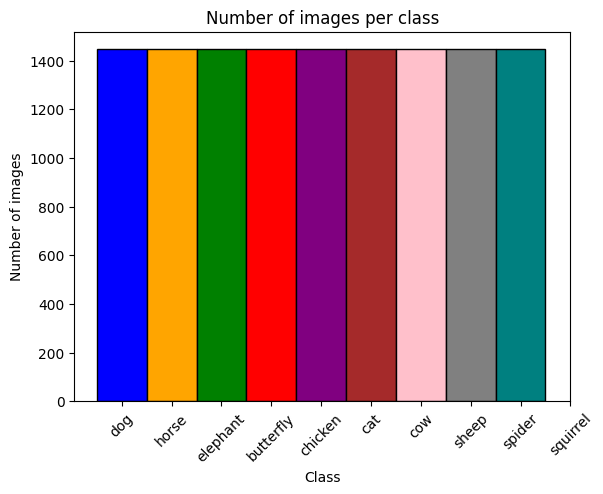

In [ ]:
# Define your class names
class_names = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

# Define a list of colors for each class
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'teal']

# Assuming 'labels' is your list of labels
n, bins, patches = plt.hist(labels, bins=np.arange(len(class_names))-0.5, edgecolor='black')

# Assuming 'labels' is your list of labels
class_counts = np.bincount(labels)

# Print the number of images for each class
for i, count in enumerate(class_counts):
    print(f'Number of images in class {class_names[i]}: {count}')

# Set the color of each bar according to the colors list
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i % len(colors)])

plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images per class')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.show()

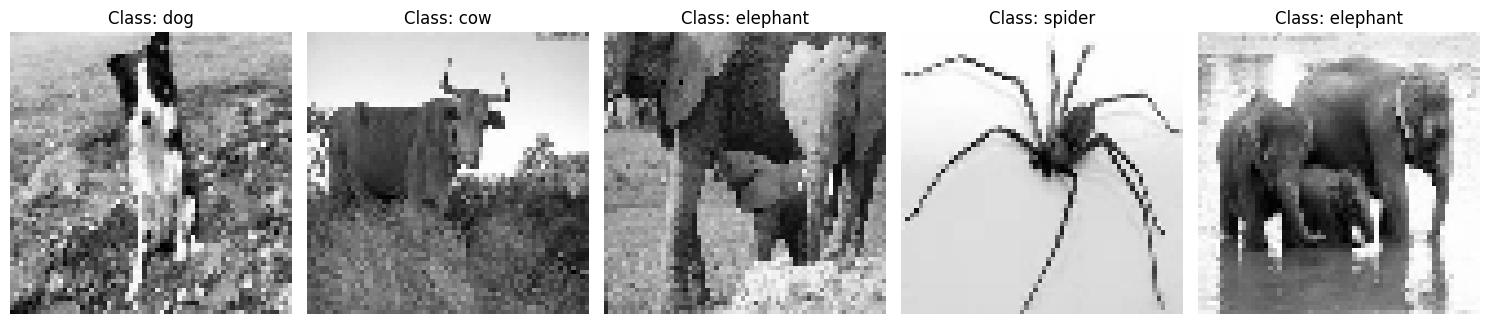

In [ ]:
# Define your class names
class_names = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

# Assuming 'data' is your list of images
num_images_to_show = 5
fig, axs = plt.subplots(1, num_images_to_show, figsize=(15, 15))  # Create a figure and a set of subplots

for i in range(num_images_to_show):
    idx = np.random.choice(range(len(data)))  # Pick a random index
    axs[i].imshow(data[idx] + 0.5, cmap = 'gray')
    axs[i].axis('off')  # Remove x and y labels
    axs[i].set_title(f'Class: {class_names[labels[idx]]}')  # Use class names instead of numbers

plt.tight_layout()
plt.show()

In [ ]:
# Train
TRAIN_SIZE = -1

train_x_vision = x_train_vision[:TRAIN_SIZE].copy().reshape(-1,64,64,1)
train_y_vision = y_train_vision[:TRAIN_SIZE].copy()

# Validation
VALIDATION_SIZE = -1

validation_x_vision = x_validation_vision[:VALIDATION_SIZE].copy().reshape(-1,64,64,1)
validation_y_vision = y_validation_vision[:VALIDATION_SIZE].copy()

# Test

TEST_SIZE = -1

test_x_vision = x_test_vision[:TEST_SIZE].copy().reshape(-1,64,64,1)
test_y_vision = y_test_vision[:TEST_SIZE].copy()

Applying PCA

In [ ]:
# PCA Dataset

# Number of principal components to retain
n_components = 20

# Create PCA object
pca = PCA(n_components=n_components)

# Train
TRAIN_SIZE = -1

pca.fit(x_train_vision[:TRAIN_SIZE].copy().reshape(-1,64*64*1))
train_x_PCA_vision = pca.transform(x_train_vision[:TRAIN_SIZE].copy().reshape(-1,64*64*1))
train_y_PCA_vision = y_train_vision[:TRAIN_SIZE].copy()

# Validation
VALIDATION_SIZE = -1

validation_x_PCA_vision = pca.transform(x_validation_vision[:VALIDATION_SIZE].copy().reshape(-1,64*64*1))
validation_y_PCA_vision = y_validation_vision[:VALIDATION_SIZE].copy()

# Test

TEST_SIZE = -1

test_x_PCA_vision = pca.transform(x_test_vision[:TEST_SIZE].copy().reshape(-1,64*64*1))
test_y_PCA_vision = y_test_vision[:TEST_SIZE].copy()

Explained variance:  65.984


#### RGB Dataset


In [ ]:
zip_file_path = '/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/archive.zip'

# Create a directory to extract the files
extract_dir = '/content/dataset'
os.makedirs(extract_dir, exist_ok=True)

# Extract files from the ZIP archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for member in tqdm(zip_ref.infolist(), desc='Extracting files'):
        zip_ref.extract(member, extract_dir)

# Load the dataset
data_dir = '/content/dataset'
data, labels = load_dataset(data_dir, image_size=(224, 224), color = 'RGB', min_label_count = 500, normalize = False)

# Shuffle the data and labels together
rng = np.random.RandomState(42)  # Set a (os, numpy, PIL, and tqdm) random seed for reproducibility
permutation = rng.permutation(len(data))
data = data[permutation]
labels = labels[permutation]

# Calculate the split indices
num_samples = len(data)
train_ratio = 0.6
validation_ratio = 0.1
train_size = int(num_samples * train_ratio)
train_validation_size = int(num_samples * (train_ratio + validation_ratio))
test_size = num_samples - train_validation_size

# Split the data into train and test and validation sets
x_train_vision_RGB, x_validation_vision_RGB, x_test_vision_RGB = data[:train_size], data[train_size:train_validation_size], data[train_validation_size:]
y_train_vision_RGB, y_validation_vision_RGB, y_test_vision_RGB = labels[:train_size], labels[train_size:train_validation_size], labels[train_validation_size:]

print("Shape of x_train: ", x_train_vision_RGB.shape)
print("Shape of y_train: ", y_train_vision_RGB.shape)
print("Shape of x_validation: ", x_validation_vision_RGB.shape)
print("Shape of y_validation: ", y_validation_vision_RGB.shape)
print("Shape of x_test: ", x_test_vision_RGB.shape)
print("Shape of y_test: ", y_test_vision_RGB.shape)

Extracting files: 100%|██████████| 26180/26180 [00:11<00:00, 2196.79it/s]


Shape of x_train:  (3000, 224, 224, 3)
Shape of y_train:  (3000,)
Shape of x_validation:  (500, 224, 224, 3)
Shape of y_validation:  (500,)
Shape of x_test:  (1500, 224, 224, 3)
Shape of y_test:  (1500,)


In [ ]:
# x_train_vision_RGB_features = model.predict(x_train_vision_RGB)
# x_validation_vision_RGB_features = model.predict(x_validation_vision_RGB)
# x_test_vision_RGB_features = model.predict(x_test_vision_RGB)

# y_train_vision_RGB_features = y_train_vision_RGB.copy()
# y_validation_vision_RGB_features = y_validation_vision_RGB.copy()
# y_test_vision_RGB_features = y_test_vision_RGB.copy()

# np.save('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/x_train_vision_RGB_features.npy', x_train_vision_RGB_features)
# np.save('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/x_validation_vision_RGB_features.npy', x_validation_vision_RGB_features)
# np.save('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/x_test_vision_RGB_features.npy', x_test_vision_RGB_features)

# np.save('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/y_train_vision_RGB_features.npy', y_train_vision_RGB_features)
# np.save('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/y_validation_vision_RGB_features.npy', y_validation_vision_RGB_features)
# np.save('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/y_test_vision_RGB_features.npy', y_test_vision_RGB_features)

In [ ]:
x_train_vision_RGB_features = np.load('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/x_train_vision_RGB_features.npy')
x_validation_vision_RGB_features = np.load('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/x_validation_vision_RGB_features.npy')
x_test_vision_RGB_features = np.load('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/x_test_vision_RGB_features.npy')

y_train_vision_RGB_features = np.load('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/y_train_vision_RGB_features.npy')
y_validation_vision_RGB_features = np.load('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/y_validation_vision_RGB_features.npy')
y_test_vision_RGB_features = np.load('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/y_test_vision_RGB_features.npy')

In [ ]:
print("Shape of x_train: ", x_train_vision_RGB_features.shape)
print("Shape of y_train: ", y_train_vision_RGB_features.shape)
print("Shape of x_validation: ", x_validation_vision_RGB_features.shape)
print("Shape of y_validation: ", y_validation_vision_RGB_features.shape)
print("Shape of x_test: ", x_test_vision_RGB_features.shape)
print("Shape of y_test: ", y_test_vision_RGB_features.shape)

Shape of x_train:  (3000, 4096)
Shape of y_train:  (3000,)
Shape of x_validation:  (500, 4096)
Shape of y_validation:  (500,)
Shape of x_test:  (1500, 4096)
Shape of y_test:  (1500,)


### **PCA**

Explained variance:  0.000
Explained variance:  74.488
Explained variance:  79.772
Explained variance:  82.578
Explained variance:  84.466
Explained variance:  85.879
Explained variance:  87.004
Explained variance:  87.938
Explained variance:  88.740
Explained variance:  89.441
Explained variance:  90.065
Explained variance:  90.628
Explained variance:  91.142
Explained variance:  91.614
Explained variance:  92.052
Explained variance:  92.458
Explained variance:  92.838
Explained variance:  93.195
Explained variance:  93.531
Explained variance:  93.848
Explained variance:  94.147


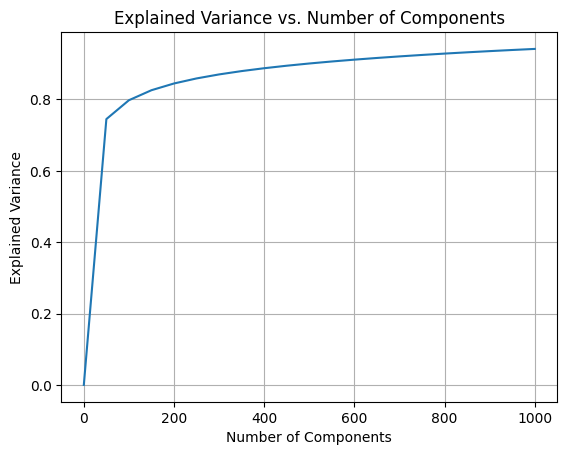

[0.0,
 0.7448805943916502,
 0.7977221068902548,
 0.8257808201188814,
 0.8446551290159061,
 0.8587918341508536,
 0.8700404491280498,
 0.879384282536036,
 0.8873974348743017,
 0.8944131379011977,
 0.9006537180886077,
 0.9062811667908725,
 0.9114164912649312,
 0.9161408610087921,
 0.920516680305598,
 0.9245849287876391,
 0.9283848774925939,
 0.9319520958960738,
 0.9353100489420728,
 0.9384779196591498,
 0.9414744206511673]

In [ ]:
# PCA Dataset

pca = PCA(n_components = 2)
pca.plot_explained_variance_vs_n_components(train_x_vision.copy().reshape(-1,64*64*1))

### **K-Means**

In [ ]:
# Initialize and fit KMeans with different distance metrics

nmi_scores_euclidean = []
nmi_scores_manhattan = []

n_clusters = np.arange(3,16,2).astype('int')

for n_cluster in n_clusters:

    kmeans_euclidean = KMeans(n_clusters=n_cluster, distance_metric='euclidean', max_iter=50)
    kmeans_manhattan = KMeans(n_clusters=n_cluster, distance_metric='manhattan', max_iter=50)

    kmeans_euclidean.fit(train_x_PCA_vision)
    kmeans_manhattan.fit(train_x_PCA_vision)

    labels_euclidean_test = kmeans_euclidean.predict(test_x_PCA_vision)
    labels_manhattan_test = kmeans_manhattan.predict(test_x_PCA_vision)

    nmi_scores_euclidean.append(calculate_nmi(test_y_PCA_vision,labels_euclidean_test))
    nmi_scores_manhattan.append(calculate_nmi(test_y_PCA_vision,labels_manhattan_test))

    print(f" NMI Score for Euclidean Distance and K = {n_cluster} :  {calculate_nmi(test_y_PCA_vision,labels_euclidean_test) :.4f}")
    print(f" NMI Score for Manhattan Distance and K = {n_cluster} :  {calculate_nmi(test_y_PCA_vision,labels_manhattan_test) :.4f}")

 NMI Score for Euclidean Distance and K = 3 :  0.0249
 NMI Score for Manhattan Distance and K = 3 :  0.0273
 NMI Score for Euclidean Distance and K = 5 :  0.0289
 NMI Score for Manhattan Distance and K = 5 :  0.0301
 NMI Score for Euclidean Distance and K = 7 :  0.0389
 NMI Score for Manhattan Distance and K = 7 :  0.0362
 NMI Score for Euclidean Distance and K = 9 :  0.0441
 NMI Score for Manhattan Distance and K = 9 :  0.0393
 NMI Score for Euclidean Distance and K = 11 :  0.0453
 NMI Score for Manhattan Distance and K = 11 :  0.0450
 NMI Score for Euclidean Distance and K = 13 :  0.0479
 NMI Score for Manhattan Distance and K = 13 :  0.0488
 NMI Score for Euclidean Distance and K = 15 :  0.0512
 NMI Score for Manhattan Distance and K = 15 :  0.0444


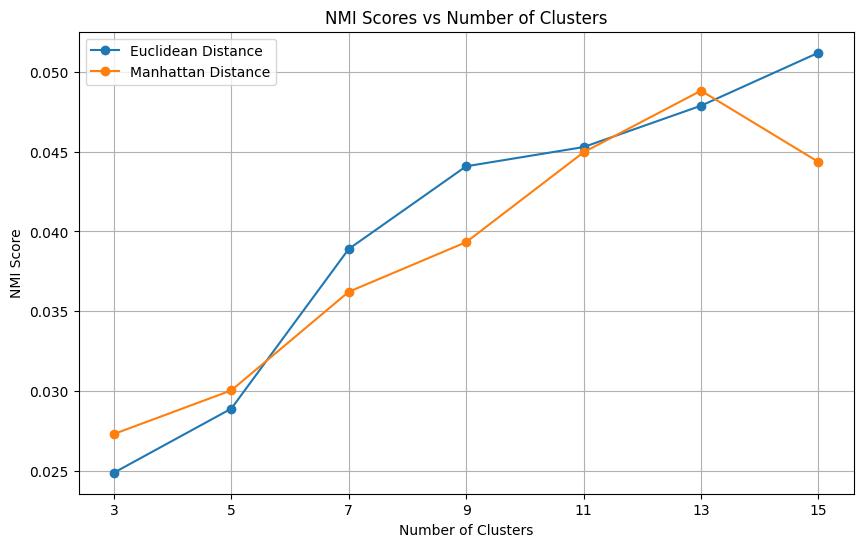

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, nmi_scores_euclidean, marker='o', label='Euclidean Distance')
plt.plot(n_clusters, nmi_scores_manhattan, marker='o', label='Manhattan Distance')
plt.title('NMI Scores vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('NMI Score')
plt.xticks(n_clusters)
plt.legend()
plt.grid(True)
plt.show()

##### Trying K - Means on PCA with n_components = 2

In [ ]:
# PCA Dataset

# Number of principal components to retain
n_components = 2

# Create PCA object
pca = PCA(n_components=n_components)

# Train
TRAIN_SIZE = -1

pca.fit(x_train_vision[:TRAIN_SIZE].copy().reshape(-1,64*64*1))
train_x_PCA = pca.transform(x_train_vision[:TRAIN_SIZE].copy().reshape(-1,64*64*1))
train_y_PCA = y_train_vision[:TRAIN_SIZE].copy()

# Validation
VALIDATION_SIZE = -1

validation_x_PCA = pca.transform(x_validation_vision[:VALIDATION_SIZE].copy().reshape(-1,64*64*1))
validation_y_PCA = y_validation_vision[:VALIDATION_SIZE].copy()

# Test

TEST_SIZE = -1

test_x_PCA = pca.transform(x_test_vision[:TEST_SIZE].copy().reshape(-1,64*64*1))
test_y_PCA = y_test_vision[:TEST_SIZE].copy()

Explained variance:  37.864


In [ ]:
# Initialize and fit KMeans with different distance metrics
n_clusters = 10

kmeans_euclidean = KMeans(n_clusters=n_clusters, distance_metric='euclidean')
kmeans_manhattan = KMeans(n_clusters=n_clusters, distance_metric='manhattan')

In [ ]:
labels_euclidean_train = kmeans_euclidean.fit(train_x_PCA)
labels_manhattan_train = kmeans_manhattan.fit(train_x_PCA)

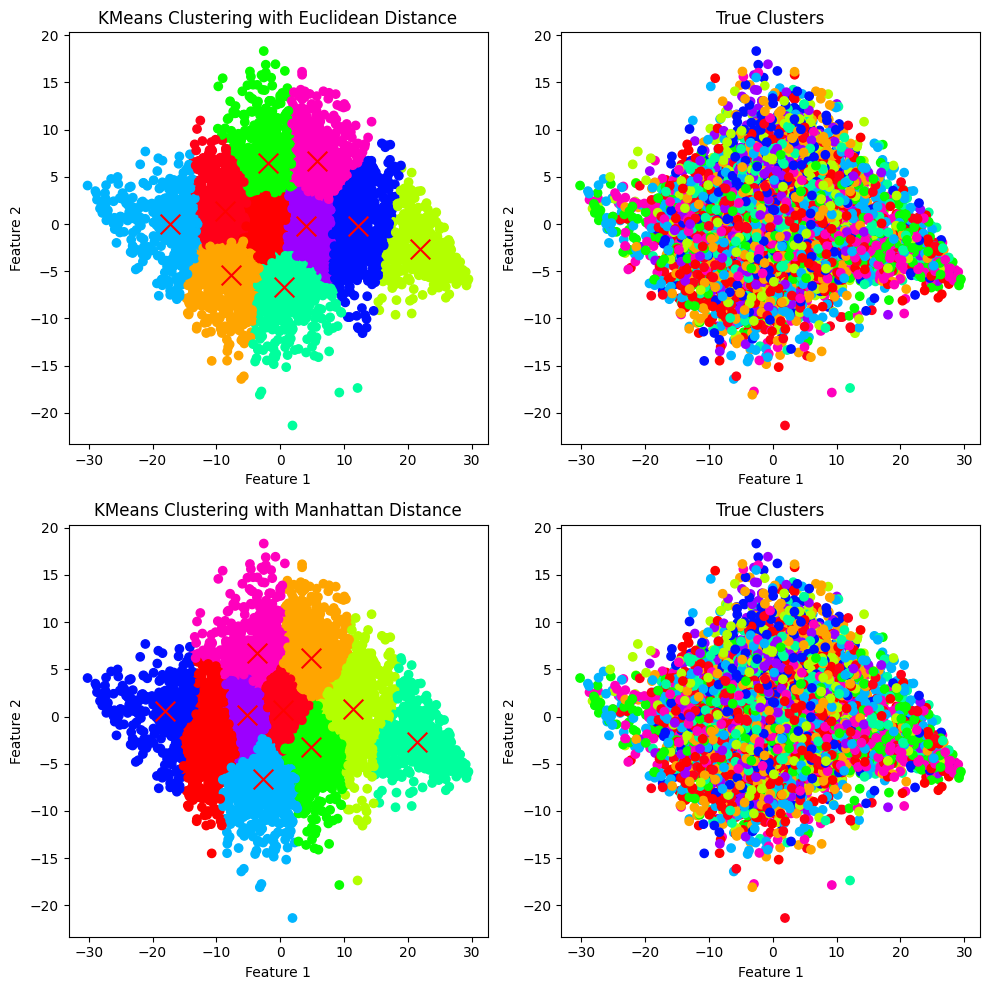

In [ ]:
# Visualize clusters
plt.figure(figsize=(10, 10))

# Plot predicetd clusters for Euclidean distance
plt.subplot(2,2, 1)
plt.scatter(train_x_PCA[:, 0], train_x_PCA[:, 1], c=labels_euclidean_train, cmap='hsv')
plt.scatter(kmeans_euclidean.cluster_centers_[:, 0], kmeans_euclidean.cluster_centers_[:, 1], marker='x', s=200, c='red')
plt.title('KMeans Clustering with Euclidean Distance')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot true clusters for Euclidean distance
plt.subplot(2,2, 2)
plt.scatter(train_x_PCA[:, 0], train_x_PCA[:, 1], c=train_y_PCA, cmap='hsv')
plt.title('True Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot clusters for Manhattan distance
plt.subplot(2,2, 3)
plt.scatter(train_x_PCA[:, 0], train_x_PCA[:, 1], c=labels_manhattan_train, cmap='hsv')
plt.scatter(kmeans_manhattan.cluster_centers_[:, 0], kmeans_manhattan.cluster_centers_[:, 1], marker='x', s=200, c='red')
plt.title('KMeans Clustering with Manhattan Distance')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot true clusters for Euclidean distance
plt.subplot(2,2, 4)
plt.scatter(train_x_PCA[:, 0], train_x_PCA[:, 1], c=train_y_PCA, cmap='hsv')
plt.title('True Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

### **MLP**

##### Training

In [ ]:
MLP_vision_network  = [
    Dense(20,256),
    LeakyReLU(),
    Dense(256,64),
    LeakyReLU(),
    Dense(64,10)
]

# Instantiate the Model object
MLP_vision = Model(MLP_vision_network)

MLP_vision.summary()

Layer (name)          | Input Shape           | Output Shape         | Trainable Parameters
-------------------------------------------------------------------------------------------
        Dense         |          20          ->         256          |       (5,376)        
      LeakyReLU       |         None         ->         None         |           -          
        Dense         |         256          ->          64          |       (16,448)       
      LeakyReLU       |         None         ->         None         |           -          
        Dense         |          64          ->          10          |        (650)         
-------------------------------------------------------------------------------------------
Total Trainable Parameters: 22,474


In [ ]:
# Train the model

MLP_vision.fit(train_x_PCA_vision, train_y_PCA_vision, validation_data = (validation_x_PCA_vision, validation_y_PCA_vision), epochs=30, batch_size = 32, learning_rate = 0.01, loss_type = 'mse')

Epoch : 1 Batch : 271/271 Training Loss 0.830 | Training Accuracy: 31.25% | Validation Loss 0.878 | Validation Accuracy : 22.28%
Epoch : 2 Batch : 271/271 Training Loss 0.846 | Training Accuracy: 34.38% | Validation Loss 0.856 | Validation Accuracy : 22.84%
Epoch : 3 Batch : 271/271 Training Loss 0.841 | Training Accuracy: 18.75% | Validation Loss 0.849 | Validation Accuracy : 26.16%
Epoch : 4 Batch : 271/271 Training Loss 0.808 | Training Accuracy: 46.88% | Validation Loss 0.838 | Validation Accuracy : 28.93%
Epoch : 5 Batch : 271/271 Training Loss 0.714 | Training Accuracy: 43.75% | Validation Loss 0.855 | Validation Accuracy : 27.27%
Epoch : 6 Batch : 271/271 Training Loss 0.810 | Training Accuracy: 40.62% | Validation Loss 0.839 | Validation Accuracy : 28.10%
Epoch : 7 Batch : 271/271 Training Loss 0.786 | Training Accuracy: 43.75% | Validation Loss 0.863 | Validation Accuracy : 25.67%
Epoch : 8 Batch : 271/271 Training Loss 0.788 | Training Accuracy: 37.50% | Validation Loss 0.839

In [ ]:
MLP_vision.save_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/MLP/MLP_PCA_Vision_30_epochs_20_features.pkl')

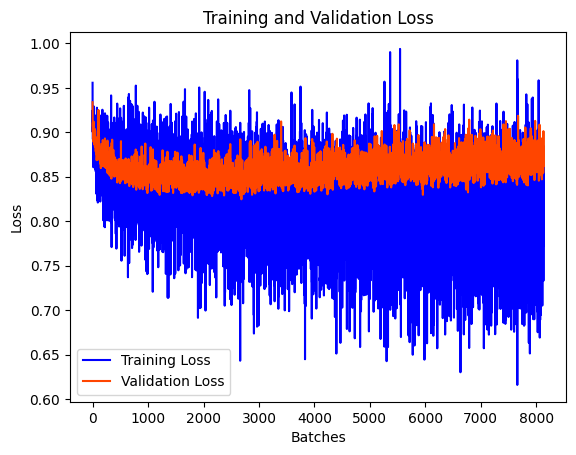

In [ ]:
# Plot the losses

plt.plot(MLP_vision.Training_loss_list, 'b', label='Training Loss')
plt.plot(MLP_vision.Validation_loss_list, 'orangered', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Testing

In [ ]:
network = []

# Instantiate the Model object
MLP_loaded = Model(network)
MLP_loaded = MLP_loaded.load_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/MLP/MLP_PCA_Vision_30_epochs_20_features.pkl')

In [ ]:
# Training Accuracy

y_pred_train = MLP_loaded.predict(train_x_PCA_vision)

print(f'Training Accuracy of MLP on Animals 10 : {accuracy(y_pred_train, train_y_PCA_vision)*100:.2f} %')
print(f'Training F1 Score of MLP on Animals 10 : {f1_score(y_pred_train, train_y_PCA_vision):.3f}')

Training Accuracy of MLP on Animals 10 : 24.20 %
Training F1 Score of MLP on Animals 10 : 0.235


In [ ]:
# Testing Accuracy

y_pred_test = MLP_loaded.predict(test_x_PCA_vision)

print(f'Testing Accuracy of MLP on Animals 10 : {accuracy(y_pred_test, test_y_PCA_vision)*100:.2f} %')
print(f'Testing F1 Score of MLP on Animals 10 : {f1_score(y_pred_test, test_y_PCA_vision):.3f}')

Testing Accuracy of MLP on Animals 10 : 26.01 %
Testing F1 Score of MLP on Animals 10 : 0.246


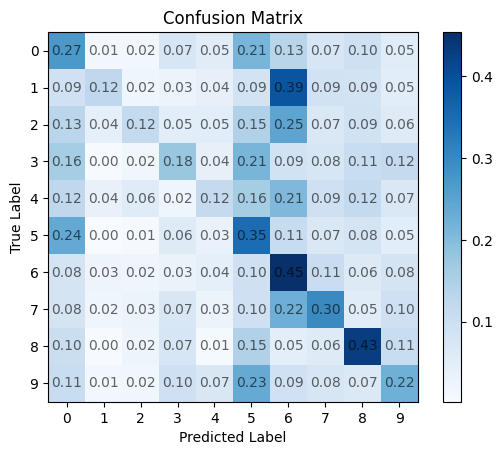

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_vision, y_pred_test))

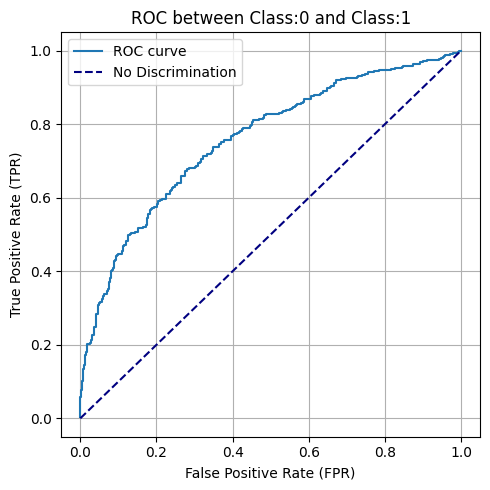

In [ ]:
plot_ROC(test_y_PCA_vision, y_pred_test,0,1)

### **MLP with Pre-trained Imagenet Model Features**

##### Training

In [ ]:
MLP_vision_Imagenet_network  = [
    Dense(4096,16),
    LeakyReLU(),
    Dense(16,10),
    LeakyReLU()
]

# Instantiate the Model object
MLP_vision_Imagenet = Model(MLP_vision_Imagenet_network)

MLP_vision_Imagenet.summary()

Layer (name)          | Input Shape           | Output Shape         | Trainable Parameters
-------------------------------------------------------------------------------------------
        Dense         |         4096         ->          16          |       (65,552)       
      LeakyReLU       |         None         ->         None         |           -          
        Dense         |          16          ->          10          |        (170)         
      LeakyReLU       |         None         ->         None         |           -          
-------------------------------------------------------------------------------------------
Total Trainable Parameters: 65,722


In [ ]:
# Train the model

MLP_vision_Imagenet.fit(x_train_vision_RGB_features, y_train_vision_RGB_features, validation_data = (x_validation_vision_RGB_features, y_validation_vision_RGB_features), epochs=10, batch_size = 32, learning_rate = 0.01, loss_type = 'mse')

Epoch : 1 Batch : 93/93 Training Loss 0.857 | Training Accuracy: 25.00% | Validation Loss 0.800 | Validation Accuracy : 34.60%
Epoch : 2 Batch : 93/93 Training Loss 0.886 | Training Accuracy: 34.38% | Validation Loss 1.001 | Validation Accuracy : 22.20%
Epoch : 3 Batch : 93/93 Training Loss 0.639 | Training Accuracy: 59.38% | Validation Loss 0.740 | Validation Accuracy : 41.20%
Epoch : 4 Batch : 93/93 Training Loss 0.703 | Training Accuracy: 56.25% | Validation Loss 0.961 | Validation Accuracy : 28.60%
Epoch : 5 Batch : 93/93 Training Loss 0.823 | Training Accuracy: 40.62% | Validation Loss 0.712 | Validation Accuracy : 44.60%
Epoch : 6 Batch : 93/93 Training Loss 0.749 | Training Accuracy: 46.88% | Validation Loss 0.634 | Validation Accuracy : 53.00%
Epoch : 7 Batch : 93/93 Training Loss 0.719 | Training Accuracy: 53.12% | Validation Loss 0.712 | Validation Accuracy : 45.60%
Epoch : 8 Batch : 93/93 Training Loss 0.704 | Training Accuracy: 50.00% | Validation Loss 0.781 | Validation Ac

In [ ]:
MLP_vision_Imagenet.save_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/MLP/MLP_Vision_Imagenet_10_epochs.pkl')

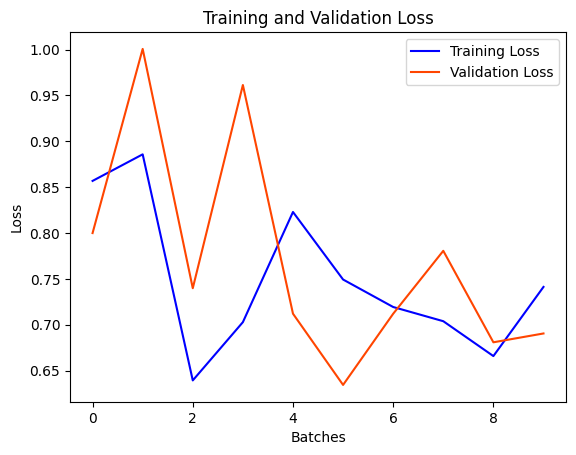

In [ ]:
# Plot the losses

plt.plot(MLP_vision_Imagenet.Training_loss_list, 'b', label='Training Loss')
plt.plot(MLP_vision_Imagenet.Validation_loss_list, 'orangered', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Testing

In [ ]:
network = []

# Instantiate the Model object
MLP_loaded = Model(network)
MLP_loaded = MLP_loaded.load_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/MLP/MLP_Vision_Imagenet_10_epochs.pkl')

In [ ]:
# Training Accuracy

y_pred_train = MLP_loaded.predict(x_train_vision_RGB_features)

print(f'Training Accuracy of MLP on Animals 10 : {accuracy(y_pred_train, y_train_vision_RGB_features)*100:.2f} %')
print(f'Training F1 Score of MLP on Animals 10 : {f1_score(y_pred_train, y_train_vision_RGB_features):.3f}')

Training Accuracy of MLP on Animals 10 : 55.17 %
Training F1 Score of MLP on Animals 10 : 0.550


In [ ]:
# Testing Accuracy

y_pred_test = MLP_loaded.predict(x_test_vision_RGB_features)

print(f'Testing Accuracy of MLP on Animals 10 : {accuracy(y_pred_test, y_test_vision_RGB_features)*100:.2f} %')
print(f'Testing F1 Score of MLP on Animals 10 : {f1_score(y_pred_test, y_test_vision_RGB_features):.3f}')

Testing Accuracy of MLP on Animals 10 : 54.87 %
Testing F1 Score of MLP on Animals 10 : 0.548


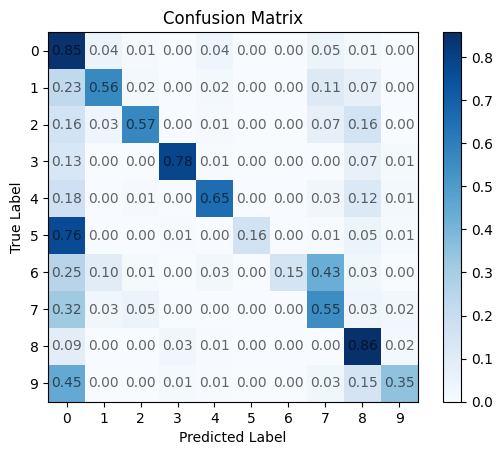

In [ ]:
confusion_matrix_heatmap(confusion_matrix(y_test_vision_RGB_features, y_pred_test))

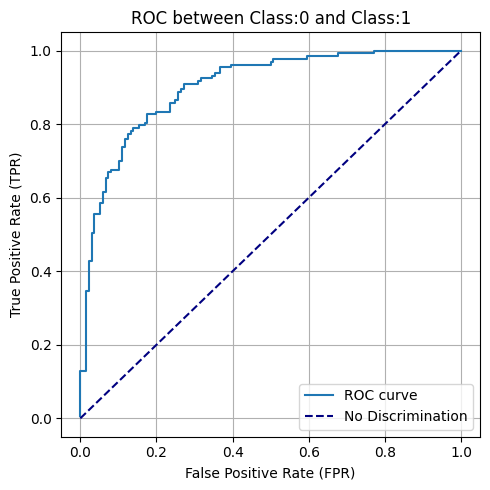

In [ ]:
plot_ROC(y_test_vision_RGB_features, y_pred_test,0,1)

### **CNN**

##### Training

In [ ]:
CNN_network  = [
    Conv(input_shape = (64,64,1), num_filters = 8, kernel_size = 3, padding = 'valid', stride = 3),
    LeakyReLU(),
    Dense_Softmax(21*21*8,10)
]

# Instantiate the Model object
CNN = Model(CNN_network)

CNN.summary()

Layer (name)          | Input Shape           | Output Shape         | Trainable Parameters
-------------------------------------------------------------------------------------------
        Conv2D        |     (64, 64, 1)      ->     (21, 21, 8)      |         (72)         
      LeakyReLU       |         None         ->         None         |           -          
    Dense_softmax     |         3528         ->          10          |       (35,290)       
-------------------------------------------------------------------------------------------
Total Trainable Parameters: 35,362


In [ ]:
# Train the model

CNN.fit(train_x_vision, train_y_vision, validation_data = (validation_x_vision, validation_y_vision), epochs=10, batch_size = 32, learning_rate = 0.01, loss_type = 'cross_entropy')

Epoch : 1 Batch : 271/271 Training Loss 2.295 | Training Accuracy: 28.12% | Validation Loss 2.287 | Validation Accuracy : 16.00%
Epoch : 2 Batch : 271/271 Training Loss 2.300 | Training Accuracy: 12.50% | Validation Loss 2.266 | Validation Accuracy : 14.00%
Epoch : 3 Batch : 271/271 Training Loss 2.287 | Training Accuracy: 12.50% | Validation Loss 2.268 | Validation Accuracy : 19.00%
Epoch : 4 Batch : 271/271 Training Loss 2.330 | Training Accuracy: 12.50% | Validation Loss 2.279 | Validation Accuracy : 14.00%
Epoch : 5 Batch : 271/271 Training Loss 2.304 | Training Accuracy: 12.50% | Validation Loss 2.272 | Validation Accuracy : 16.00%
Epoch : 6 Batch : 271/271 Training Loss 2.129 | Training Accuracy: 15.62% | Validation Loss 2.297 | Validation Accuracy : 15.00%
Epoch : 7 Batch : 271/271 Training Loss 2.244 | Training Accuracy: 28.12% | Validation Loss 2.305 | Validation Accuracy : 14.00%
Epoch : 8 Batch : 271/271 Training Loss 2.356 | Training Accuracy: 3.12% | Validation Loss 2.340 

In [ ]:
CNN.save_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/CNN/CNN_Vision_10_epochs_run2.pkl')

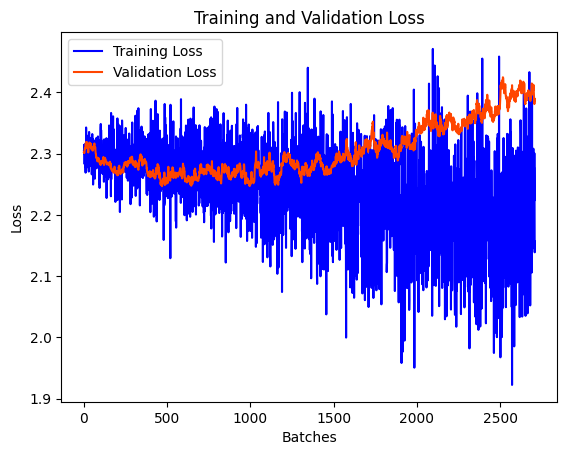

In [ ]:
# Plot the losses

plt.plot(CNN.Training_loss_list, 'b', label='Training Loss')
plt.plot(CNN.Validation_loss_list, 'orangered', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Testing

In [ ]:
network = []

# Instantiate the Model object
CNN_loaded = Model(network)
CNN_loaded = CNN_loaded.load_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/CNN/CNN_Vision_30_epochs.pkl')

In [ ]:
# Training Accuracy

y_pred_train = CNN_loaded.predict(train_x_vision)

print(f'Training Accuracy of CNN on Animals10 Dataset : {accuracy(y_pred_train, train_y_vision)*100:.2f} %')
print(f'Training F1 Score of CNN on Animals10 Dataset : {f1_score(y_pred_train, train_y_vision):.3f}')

Training Accuracy of CNN on Animals10 Dataset : 17.63 %
Training F1 Score of CNN on Animals10 Dataset : 0.142


In [ ]:
# Testing Accuracy

y_pred_test = CNN_loaded.predict(test_x_vision)

print(f'Testing Accuracy of CNN on Animals10 Dataset : {accuracy(y_pred_test, test_y_vision)*100:.2f} %')
print(f'Testing F1 Score of CNN on Animals10 Dataset : {f1_score(y_pred_test, test_y_vision):.3f}')

Testing Accuracy of CNN on Animals10 Dataset : 17.20 %
Testing F1 Score of CNN on Animals10 Dataset : 0.143


In [ ]:
# Testing Accuracy

y_pred_test = CNN_loaded.predict(test_x_vision)

print(f'Testing Accuracy of CNN on Animals10 Dataset : {accuracy(y_pred_test, test_y_vision)*100:.2f} %')
print(f'Testing F1 Score of CNN on Animals10 Dataset : {f1_score(y_pred_test, test_y_vision):.3f}')

Testing Accuracy of CNN on Animals10 Dataset : 17.50 %
Testing F1 Score of CNN on Animals10 Dataset : 0.144


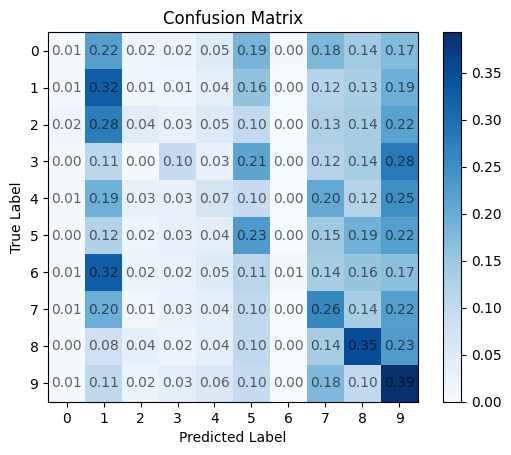

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_vision, y_pred_test))

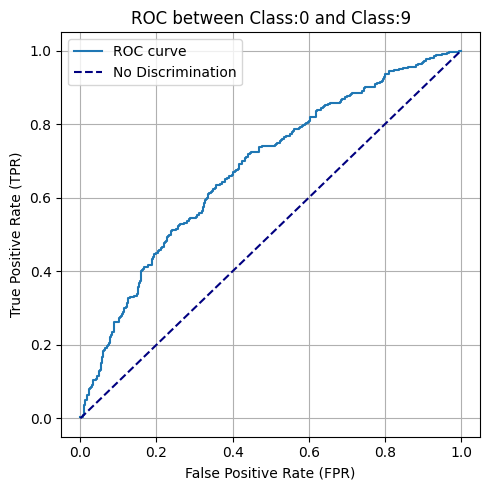

In [ ]:
plot_ROC(test_y_vision, y_pred_test,0,9)

### **Decision Tree**

Loss - Gini

In [ ]:
DT_vision = DecisionTree(max_depth=5, criterion='gini')

# Fit the tree to the training data
DT_vision.fit(train_x_PCA_vision, train_y_PCA_vision)

In [ ]:
# Training Accuracy

y_pred_train = DT_vision.predict(train_x_PCA_vision)

print(f'Training Accuracy of MLP on Vision Dataset : {accuracy(y_pred_train, train_y_PCA_vision)*100:.2f} %')
print(f'Training F1 Score of MLP on Vision Dataset : {f1_score(y_pred_train, train_y_PCA_vision):.3f}')

Training Accuracy of MLP on Vision Dataset : 21.06 %
Training F1 Score of MLP on Vision Dataset : 0.199


In [ ]:
# Testing Accuracy

y_pred_test = DT_vision.predict(test_x_PCA_vision)

print(f'Testing Accuracy of MLP on vision Dataset : {accuracy(y_pred_test, test_y_PCA_vision)*100:.2f} %')
print(f'Testing F1 Score of MLP on vision Dataset : {f1_score(y_pred_test, test_y_PCA_vision):.3f}')

Testing Accuracy of MLP on vision Dataset : 18.88 %
Testing F1 Score of MLP on vision Dataset : 0.177


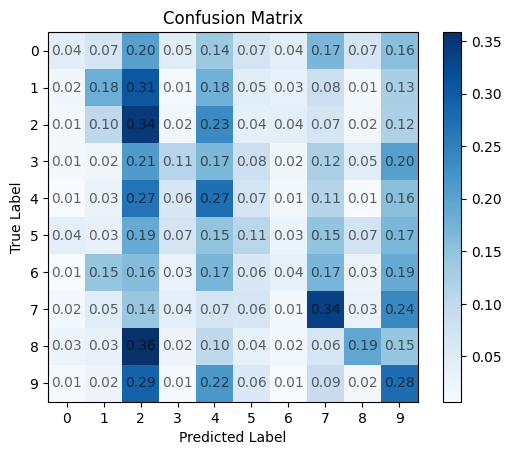

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_vision, y_pred_test))

Loss - Entropy

In [ ]:
DT_vision = DecisionTree(max_depth=5, criterion='entropy')

# Fit the tree to the training data
DT_vision.fit(train_x_PCA_vision, train_y_PCA_vision)

In [ ]:
# Training Accuracy

y_pred_train = DT_vision.predict(train_x_PCA_vision)

print(f'Training Accuracy of MLP on Vision Dataset : {accuracy(y_pred_train, train_y_PCA_vision)*100:.2f} %')
print(f'Training F1 Score of MLP on Vision Dataset : {f1_score(y_pred_train, train_y_PCA_vision):.3f}')

Training Accuracy of MLP on Vision Dataset : 18.04 %
Training F1 Score of MLP on Vision Dataset : 0.169


In [ ]:
# Testing Accuracy

y_pred_test = DT_vision.predict(test_x_PCA_vision)

print(f'Testing Accuracy of MLP on vision Dataset : {accuracy(y_pred_test, test_y_PCA_vision)*100:.2f} %')
print(f'Testing F1 Score of MLP on vision Dataset : {f1_score(y_pred_test, test_y_PCA_vision):.3f}')

Testing Accuracy of MLP on vision Dataset : 15.54 %
Testing F1 Score of MLP on vision Dataset : 0.147


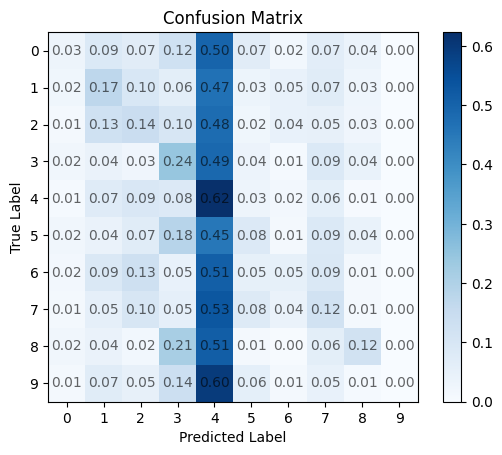

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_vision, y_pred_test))

### **AdaBoost**

###### Ensemble of MLP

In [ ]:
clf = Adaboost(n_clf=15)
clf.fit(train_x_PCA_vision, train_y_PCA_vision)

Learner:  1
Alpha:  1.3736924837056796
Accuracy of current classifier:  0.30501440922190204
Exp Loss:  2.001375232866769
Accuracy of Ensemble classifier till now:  0.09590778097982709
Learner:  2
Alpha:  1.0576197103099716
Accuracy of current classifier:  0.2418443804034582
Exp Loss:  2.001375232866769
Accuracy of Ensemble classifier till now:  0.30501440922190204
Learner:  3
Alpha:  1.0035794527428978
Accuracy of current classifier:  0.2261671469740634
Exp Loss:  1.9924342209035995
Accuracy of Ensemble classifier till now:  0.30501440922190204
Learner:  4
Alpha:  0.8866001218985315
Accuracy of current classifier:  0.22086455331412103
Exp Loss:  1.9753650162466405
Accuracy of Ensemble classifier till now:  0.30881844380403456
Learner:  5
Alpha:  0.8612246170493612
Accuracy of current classifier:  0.20979827089337175
Exp Loss:  1.9688624620916086
Accuracy of Ensemble classifier till now:  0.3160806916426513
Learner:  6
Alpha:  0.7820239113269076
Accuracy of current classifier:  0.189279

In [ ]:
# Training Accuracy

y_pred_train = clf.predict(train_x_PCA_vision)

In [ ]:
# Testing Accuracy

y_pred_test = clf.predict(test_x_PCA_vision)

In [ ]:
print(f'Training Accuracy of MLP on Animals 10 : {accuracy(y_pred_train, train_y_PCA_vision)*100:.2f} %')
print(f'Training F1 Score of MLP on Animals 10 : {f1_score(y_pred_train, train_y_PCA_vision):.3f}')

print(f'Testing Accuracy of MLP on Animals 10 : {accuracy(y_pred_test, test_y_PCA_vision)*100:.2f} %')
print(f'Testing F1 Score of MLP on Animals 10 : {f1_score(y_pred_test, test_y_PCA_vision):.3f}')

Training Accuracy of MLP on Animals 10 : 33.05 %
Training F1 Score of MLP on Animals 10 : 0.330
Testing Accuracy of MLP on Animals 10 : 26.40 %
Testing F1 Score of MLP on Animals 10 : 0.265


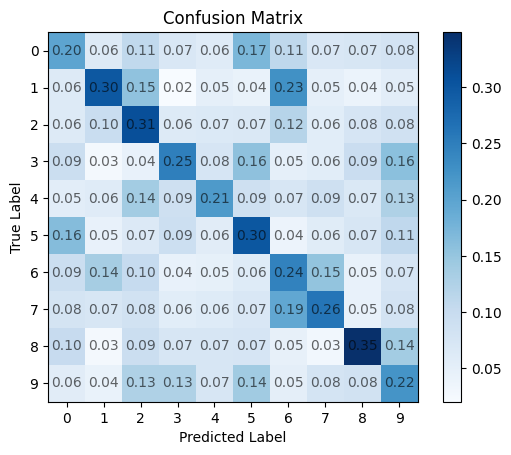

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_vision, y_pred_test))

| Number of Learners (MLPs) | Train Accuracy | Test Accuracy | Exponential Loss |
|--------------------|----------------|---------------|------------------|
| 3                  | 0.3126         | 0.2489        | 1.95775          |
| 7                  | 0.3209         | 0.2543        | 1.94935          |
| 11                 | 0.3387         | 0.2684        | 1.9222           |
| 15                 | 0.3305         | 0.2640        | 1.9414           |


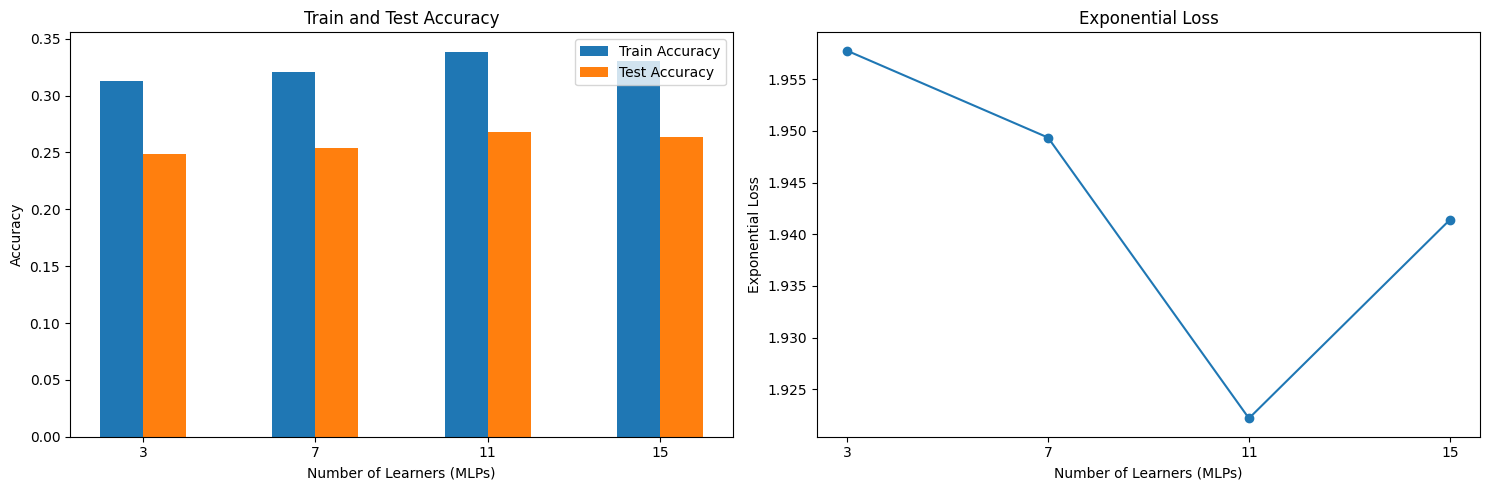

In [ ]:
# Data
number_of_learners = [3, 7, 11, 15]
train_accuracy = [0.3126, 0.3209, 0.3387, 0.3305]
test_accuracy = [0.2489, 0.2543, 0.2684, 0.2640]
exp_loss = [1.95775, 1.94935, 1.9222, 1.9414]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Training and Testing Accuracy
bar_width = 1
bar_positions_train = [x - bar_width/2 for x in number_of_learners]
bar_positions_test = [x + bar_width/2 for x in number_of_learners]

axs[0].bar(bar_positions_train, train_accuracy, width=bar_width, label='Train Accuracy')
axs[0].bar(bar_positions_test, test_accuracy, width=bar_width, label='Test Accuracy')
axs[0].set_xticks(number_of_learners)
axs[0].set_xlabel('Number of Learners (MLPs)')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Train and Test Accuracy')
axs[0].legend()

# Exponential Loss
axs[1].plot(number_of_learners, exp_loss, marker='o')
axs[1].set_xticks(number_of_learners)
axs[1].set_xlabel('Number of Learners (MLPs)')
axs[1].set_ylabel('Exponential Loss')
axs[1].set_title('Exponential Loss')

plt.tight_layout()
plt.show()


###### Ensemble of CNN

In [ ]:
n_clf = 9
clf = Adaboost(n_clf=n_clf, clf_type = 'CNN')
clf.fit(train_x_vision[:2000], train_y_vision[:2000])

Learner:  1
Alpha:  0.7983830005446009
Accuracy of current classifier:  0.198
Exp Loss:  2.2529021557760998
Accuracy of Ensemble classifier till now:  0.0855
Learner:  2
Alpha:  0.7324967640678466
Accuracy of current classifier:  0.186
Exp Loss:  2.2529021557760998
Accuracy of Ensemble classifier till now:  0.198
Learner:  3
Alpha:  0.5193153097839234
Accuracy of current classifier:  0.159
Exp Loss:  2.231748534290511
Accuracy of Ensemble classifier till now:  0.198
Learner:  4
Alpha:  0.9171110075942748
Accuracy of current classifier:  0.2115
Exp Loss:  2.170638072221034
Accuracy of Ensemble classifier till now:  0.207
Learner:  5
Alpha:  0.616744851337037
Accuracy of current classifier:  0.167
Exp Loss:  2.174163675801965
Accuracy of Ensemble classifier till now:  0.233
Learner:  6
Alpha:  0.5637670969907262
Accuracy of current classifier:  0.1565
Exp Loss:  2.1847404865447593
Accuracy of Ensemble classifier till now:  0.2315
Learner:  7
Alpha:  0.552172478834748
Accuracy of current 

In [ ]:
# clf.save_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/AdaBoost/AdaBoost_3_CNNs_vision.pkl')

In [ ]:
# clf = Adaboost(n_clf=3, clf_type = 'CNN')
# clf.load_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/AdaBoost/AdaBoost_3_CNNs_vision.pkl')

In [ ]:
# Training Accuracy

y_pred_train = clf.predict(train_x_vision)

print(f'Training Accuracy of Ensemble of CNNs (number of CNNs = {n_clf}) on Vision Dataset : {accuracy(y_pred_train, train_y_vision)*100:.2f} %')
print(f'Training F1 Score of Ensemble of CNNs (number of CNNs = {n_clf}) on Vision Dataset : {f1_score(y_pred_train, train_y_vision):.3f}')

Training Accuracy of Ensemble of CNNs (number of CNNs = 9) on Vision Dataset : 16.39 %
Training F1 Score of Ensemble of CNNs (number of CNNs = 9) on Vision Dataset : 0.157


In [ ]:
# Testing Accuracy

y_pred_test = clf.predict(test_x_vision)

print(f'Testing Accuracy of Ensemble of CNNs (number of CNNs = {n_clf}) on Vision Dataset : {accuracy(y_pred_test, test_y_vision)*100:.2f} %')
print(f'Testing F1 Score of Ensemble of CNNs (number of CNNs = {n_clf}) on Vision Dataset : {f1_score(y_pred_test, test_y_vision):.3f}')

Testing Accuracy of Ensemble of CNNs (number of CNNs = 9) on Vision Dataset : 15.01 %
Testing F1 Score of Ensemble of CNNs (number of CNNs = 9) on Vision Dataset : 0.146


In [ ]:
print(f'Exp Loss of Ensemble of CNNs (number of learners = {n_clf}) on Vision Dataset : {clf.loss[-1]}')

Exp Loss of Ensemble of CNNs (number of learners = 9) on Vision Dataset : 2.1659372674464583


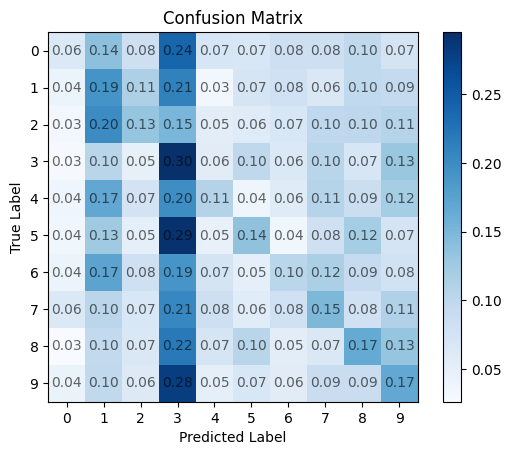

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_vision, y_pred_test))

| Number of CNNs | Training Accuracy | Training F1 Score | Testing Accuracy | Testing F1 Score | Expected Loss |
|----------------|-------------------|-------------------|------------------|------------------|---------------|
| 3              | 15.18%            | 0.145             | 14.18%           | 0.138            | 2.270         |
| 5              | 15.26%            | 0.148             | 14.47%           | 0.140            | 2.241         |
| 7              | 15.73%            | 0.151             | 14.78%           | 0.142            | 2.225         |
| 9              | 16.39%            | 0.157             | 15.01%           | 0.146            | 2.166         |


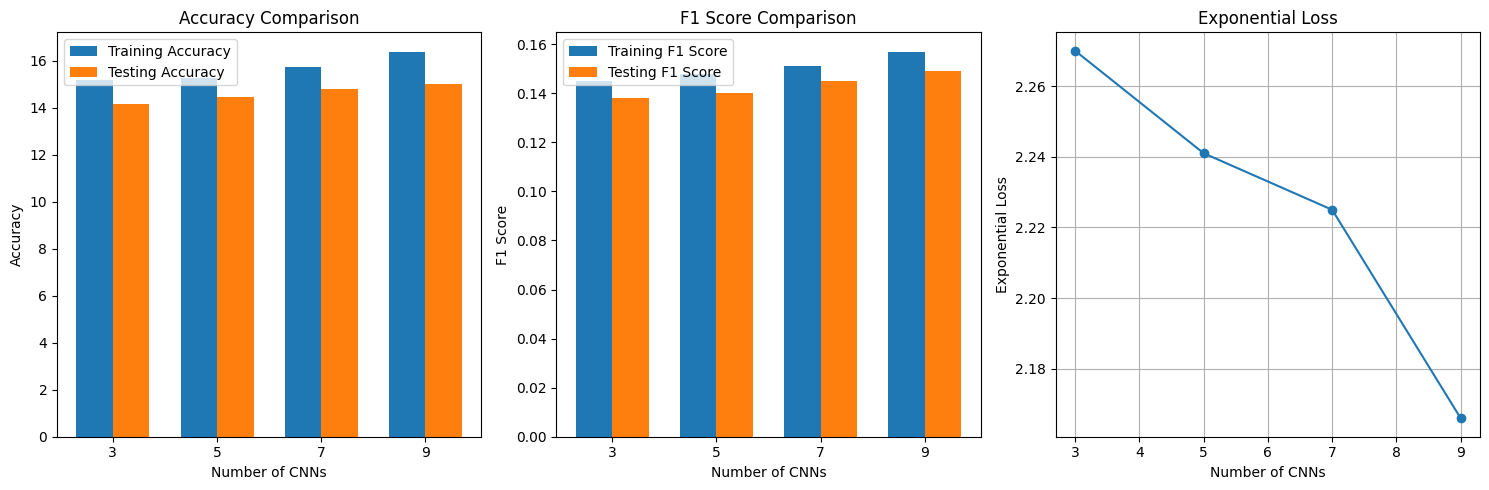

In [ ]:
# Data
num_cnns = [3, 5, 7, 9]
training_accuracy = [15.18, 15.26, 15.73, 16.39]
testing_accuracy = [14.18, 14.47, 14.78, 15.01]
training_f1 = [0.145, 0.148, 0.151, 0.157]
testing_f1 = [0.138, 0.140, 0.145, 0.149]
exp_loss = [2.270, 2.241, 2.225, 2.166]

# Plotting
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 3, 1)
bar_width = 0.35
index = range(len(num_cnns))
plt.bar(index, training_accuracy, bar_width, label='Training Accuracy')
plt.bar([i + bar_width for i in index], testing_accuracy, bar_width, label='Testing Accuracy')
plt.xlabel('Number of CNNs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks([i + bar_width/2 for i in index], num_cnns)
plt.legend()

# F1 Score
plt.subplot(1, 3, 2)
plt.bar(index, training_f1, bar_width, label='Training F1 Score')
plt.bar([i + bar_width for i in index], testing_f1, bar_width, label='Testing F1 Score')
plt.xlabel('Number of CNNs')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.xticks([i + bar_width/2 for i in index], num_cnns)
plt.legend()

# Exponential Loss
plt.subplot(1, 3, 3)
plt.plot(num_cnns, exp_loss, marker='o')
plt.xlabel('Number of CNNs')
plt.ylabel('Exponential Loss')
plt.title('Exponential Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


###### Ensemble of DT

In [ ]:
n_clf = 9
clf = Adaboost(n_clf=n_clf, clf_type = 'Decision Tree')
clf.fit(train_x_PCA_vision, train_y_PCA_vision)

Learner:  1
Alpha:  0.8094886710057054
Accuracy of current classifier:  0.19976945244956773
Exp Loss:  2.2487432305144437
Accuracy of Ensemble classifier till now:  0.09717579250720461
Learner:  2
Alpha:  0.7358319226815444
Accuracy of current classifier:  0.18536023054755044
Exp Loss:  2.2487432305144437
Accuracy of Ensemble classifier till now:  0.19976945244956773
Learner:  3
Alpha:  0.6798567821392043
Accuracy of current classifier:  0.1768299711815562
Exp Loss:  2.2273389897541302
Accuracy of Ensemble classifier till now:  0.19976945244956773
Learner:  4
Alpha:  0.5640965931292323
Accuracy of current classifier:  0.15896253602305477
Exp Loss:  2.2127082429053084
Accuracy of Ensemble classifier till now:  0.20887608069164265
Learner:  5
Alpha:  0.6022684154448044
Accuracy of current classifier:  0.1867435158501441
Exp Loss:  2.166377544550705
Accuracy of Ensemble classifier till now:  0.21510086455331412
Learner:  6
Alpha:  0.5329431483712903
Accuracy of current classifier:  0.1468

In [ ]:
clf.save_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/AdaBoost/AdaBoost_9_DTs_vision.pkl')

In [ ]:
# n_clf = 9
# clf = Adaboost(n_clf=n_clf, clf_type = 'Decision Tree')
# clf.load_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/AdaBoost/AdaBoost_9_DTs_vision.pkl')

In [ ]:
# Training Accuracy

y_pred_train = clf.predict(train_x_PCA_vision)

In [ ]:
# Testing Accuracy

y_pred_test = clf.predict(test_x_PCA_vision)

In [ ]:
print(f'Training Accuracy of Ensemble of DTs (number of Trees = {n_clf}) on Animals 10 : {accuracy(y_pred_train, train_y_PCA_vision)*100:.2f} %')
print(f'Training F1 Score of Ensemble of DTs (number of Trees = {n_clf}) on Animals 10 : {f1_score(y_pred_train, train_y_PCA_vision):.3f}')

print(f'Testing Accuracy of Ensemble of DTs (number of Trees = {n_clf}) on Animals 10 : {accuracy(y_pred_test, test_y_PCA_vision)*100:.2f} %')
print(f'Testing F1 Score of Ensemble of DTs (number of Trees = {n_clf}) on Animals 10 : {f1_score(y_pred_test, test_y_PCA_vision):.3f}')


print(f'Exp Loss of Ensemble of DTs (number of Trees = {n_clf}) on Animals 10 : {clf.loss[-1]}')

Training Accuracy of Ensemble of DTs (number of Trees = 9) on Animals 10 : 25.10 %
Training F1 Score of Ensemble of DTs (number of Trees = 9) on Animals 10 : 0.245
Testing Accuracy of Ensemble of DTs (number of Trees = 9) on Animals 10 : 21.19 %
Testing F1 Score of Ensemble of DTs (number of Trees = 9) on Animals 10 : 0.203
Exp Loss of Ensemble of DTs (number of Trees = 9) on Animals 10 : 2.128445978646352


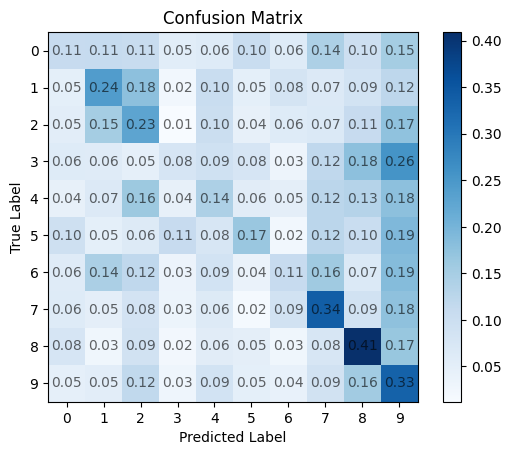

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_vision, y_pred_test))

| Number of Trees | Training Accuracy | Training F1 Score | Testing Accuracy | Testing F1 Score | Exponential Loss |
|-----------------|-------------------|-------------------|------------------|------------------|---------------|
| 3               | 20.89%            | 0.191             | 19.18%           | 0.172            | 2.227         |
| 5               | 21.82%            | 0.216             | 18.54%           | 0.178            | 2.205         |
| 7               | 24.20%            | 0.239             | 22.14%           | 0.215            | 2.150         |
| 9               | 24.67%            | 0.242             | 20.98%           | 0.205            | 2.138         |


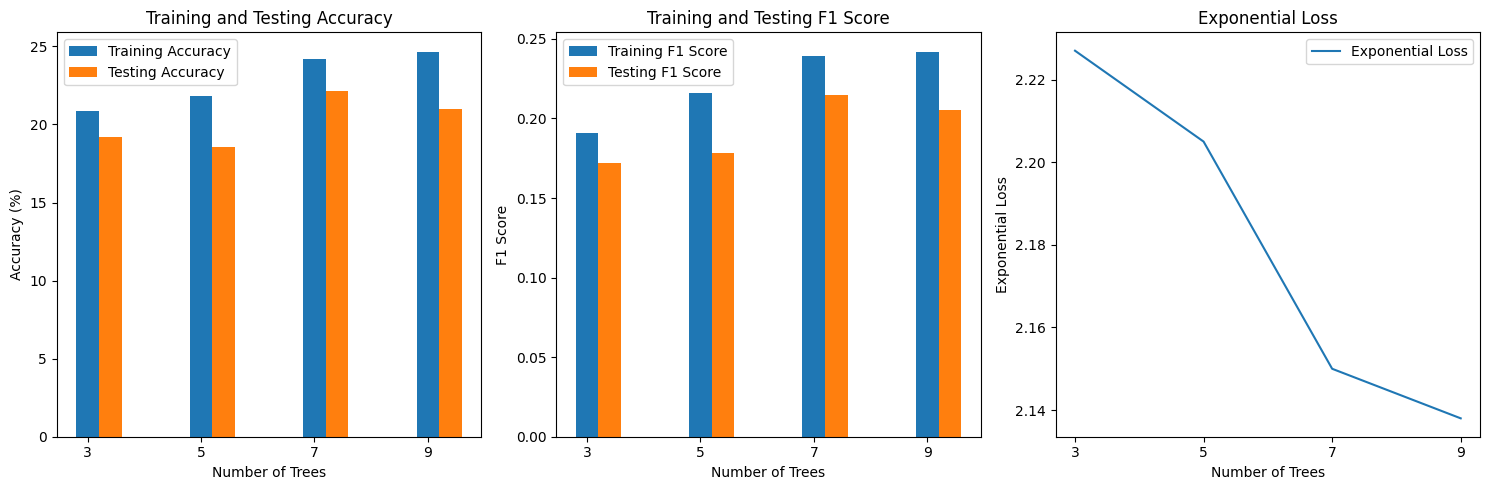

In [ ]:
# Data
number_of_trees = [3, 5, 7, 9]
training_accuracy = [20.89, 21.82, 24.20, 24.67]
training_f1_score = [0.191, 0.216, 0.239, 0.242]
testing_accuracy = [19.18, 18.54, 22.14, 20.98]
testing_f1_score = [0.172, 0.178, 0.215, 0.205]
exp_loss = [2.227, 2.205, 2.150, 2.138]

# Plotting
fig, axs = plt.subplots(1,3, figsize=(15, 5))

# Training Accuracy and Testing Accuracy
axs[0].bar(number_of_trees, training_accuracy, label='Training Accuracy', width=0.4, align='center')
axs[0].bar([x + 0.4 for x in number_of_trees], testing_accuracy, label='Testing Accuracy', width=0.4, align='center')
axs[0].set_xticks(number_of_trees)
axs[0].set_xlabel('Number of Trees')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Training and Testing Accuracy')
axs[0].legend()

# Training F1 Score and Testing F1 Score
axs[1].bar(number_of_trees, training_f1_score, label='Training F1 Score', width=0.4, align='center')
axs[1].bar([x + 0.4 for x in number_of_trees], testing_f1_score, label='Testing F1 Score', width=0.4, align='center')
axs[1].set_xticks(number_of_trees)
axs[1].set_xlabel('Number of Trees')
axs[1].set_ylabel('F1 Score')
axs[1].set_title('Training and Testing F1 Score')
axs[1].legend()

# Exponential Loss
axs[2].plot(number_of_trees, exp_loss, label='Exponential Loss')
axs[2].set_xticks(number_of_trees)
axs[2].set_xlabel('Number of Trees')
axs[2].set_ylabel('Exponential Loss')
axs[2].set_title('Exponential Loss')
axs[2].legend()

plt.tight_layout()
plt.show()


### **Results Comparison**

| Model                                                  | Testing Accuracy | Testing F1 Score |
|--------------------------------------------------------|------------------|------------------|
| MLP                                                    | 26.01%           | 0.246            |
| MLP (With Imagenet Features)                           | 54.87%           | 0.548            |
| CNN                                                    | 17.20%           | 0.143            |
| Decision Tree (Gini)                                  | 18.88%           | 0.177            |
| Decision Tree (Entropy)                               | 15.54%           | 0.147            |
| Ensemble of MLPs (n = 9)                              | 26.40%           | 0.265            |
| Ensemble of CNNs (number of CNNs = 9)                 | 15.01%           | 0.146            |
| Ensemble of Decision Trees (number of Trees = 9)      | 21.19%           | 0.203            |
| Self Attention                                         | 24.10%           | 0.239            |

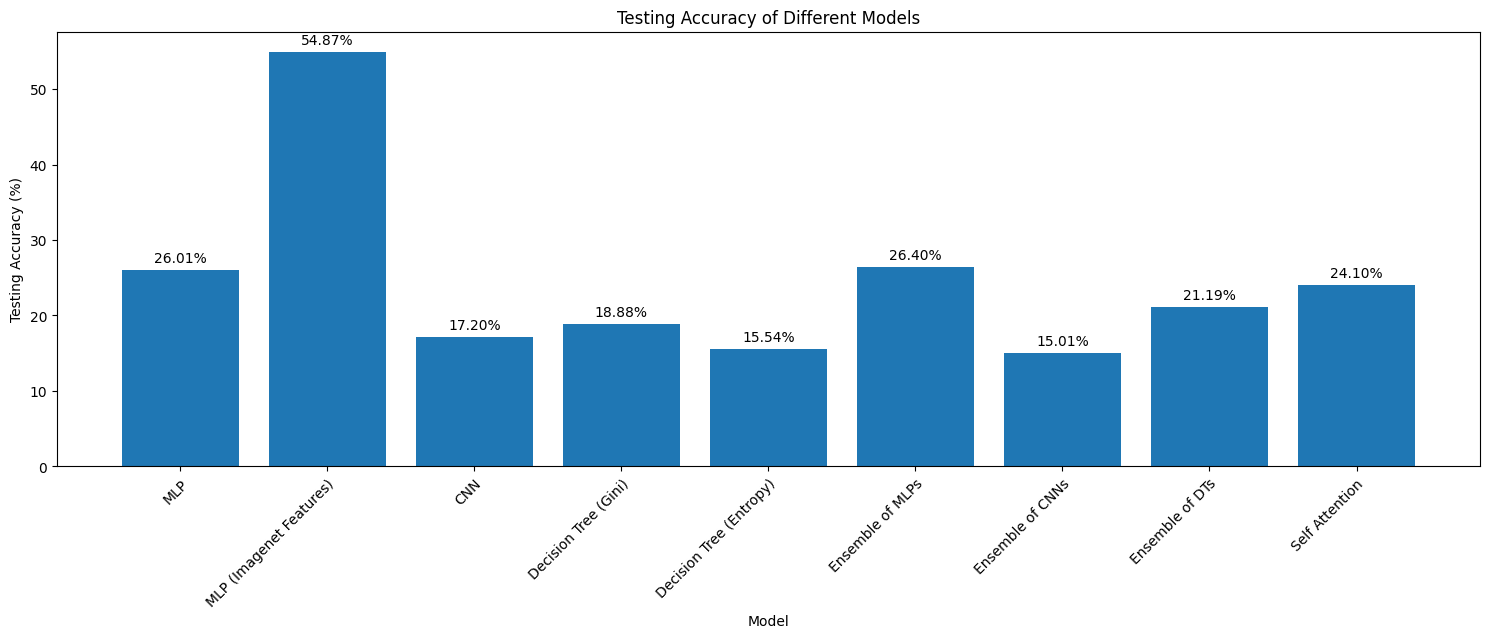

In [ ]:
# Data
models = ['MLP', 'MLP (Imagenet Features)', 'CNN', 'Decision Tree (Gini)',
          'Decision Tree (Entropy)', 'Ensemble of MLPs',
          'Ensemble of CNNs', 'Ensemble of DTs', 'Self Attention']

accuracies = [26.01, 54.87, 17.20, 18.88, 15.54, 26.40, 15.01, 21.19, 24.10]

# Plot
plt.figure(figsize=(15, 6))
plt.bar(models, accuracies)

# Adding accuracy values on top of the bars
for i in range(len(models)):
    plt.text(i, accuracies[i] + 1, f"{accuracies[i]:.2f}%", ha='center')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracy of Different Models')
plt.xticks(rotation = 45, ha = 'right', fontsize = 10, wrap = True)

# Show plot
plt.tight_layout()
plt.show()


## **Text Dataset**

### **Loading Text Data**

In [ ]:
text_df = pd.read_json('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/News_Category_Dataset_v3.json', lines=True)
columns = ['headline', 'category']
text_df = text_df[columns]
text_df.head()

headline   category
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY
3  The Funniest Tweets From Parents This Week (Se...  PARENTING
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS

In [ ]:
# Count the occurrences of each category
category_counts = text_df['category'].value_counts()

# Select the top 12 categories by occurrences
top_categories = category_counts.head(12).index.tolist()

# Filter the dataframe to keep only the rows with top categories
filtered_df = text_df[text_df['category'].isin(top_categories)]

# One-hot encode the categories
one_hot_encoded = pd.get_dummies(filtered_df['category'])
labels = np.argmax(one_hot_encoded.to_numpy().astype('int'),axis = 1)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 100)

# Fit and transform the headlines using TF-IDF
headline_embeddings = tfidf_vectorizer.fit_transform(filtered_df['headline'])

In [ ]:
x_text = headline_embeddings.toarray()
y_text = labels.copy()

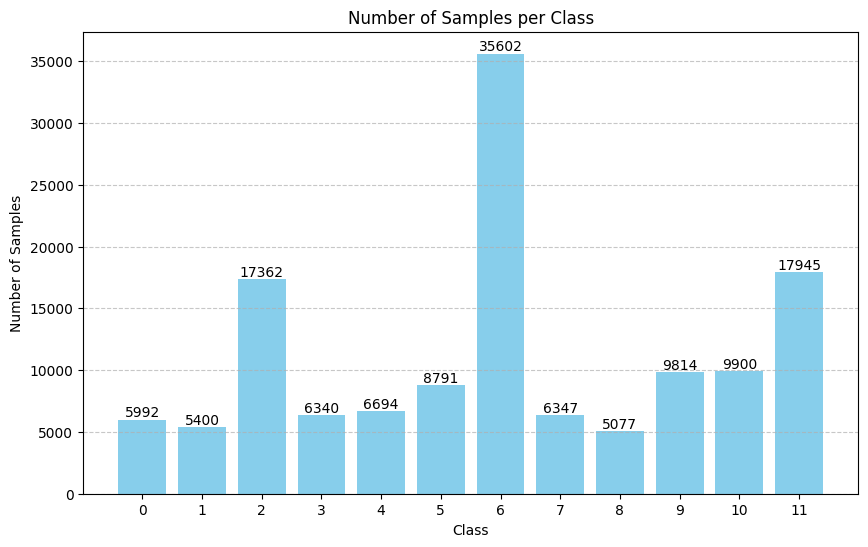

In [ ]:
# Get unique labels and their counts
unique_classes, counts = np.unique(y_text, return_counts=True)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(unique_classes)  # Ensure all classes are labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, count,
             ha='center', va='bottom')

plt.show()

In [ ]:
# Determine the minimum number of samples among all classes
min_samples = np.min(np.bincount(y_text))

# Initialize lists to store balanced subsets
balanced_x_text = []
balanced_y_text = []

# Select a subset of samples from each class
for label in np.unique(y_text):
    # Get indices of samples with current label
    indices = np.where(y_text == label)[0]

    # select min_samples indices
    selected_indices = indices[:min_samples]

    # Append selected samples to balanced dataset
    balanced_x_text.extend(x_text[selected_indices])
    balanced_y_text.extend(y_text[selected_indices])

# Convert lists to numpy arrays
balanced_x_text = np.array(balanced_x_text)
balanced_y_text = np.array(balanced_y_text)

# Shuffle the balanced dataset
shuffled_indices = np.arange(len(balanced_x_text))
np.random.shuffle(shuffled_indices)
balanced_x_text = balanced_x_text[shuffled_indices]
balanced_y_text = balanced_y_text[shuffled_indices]

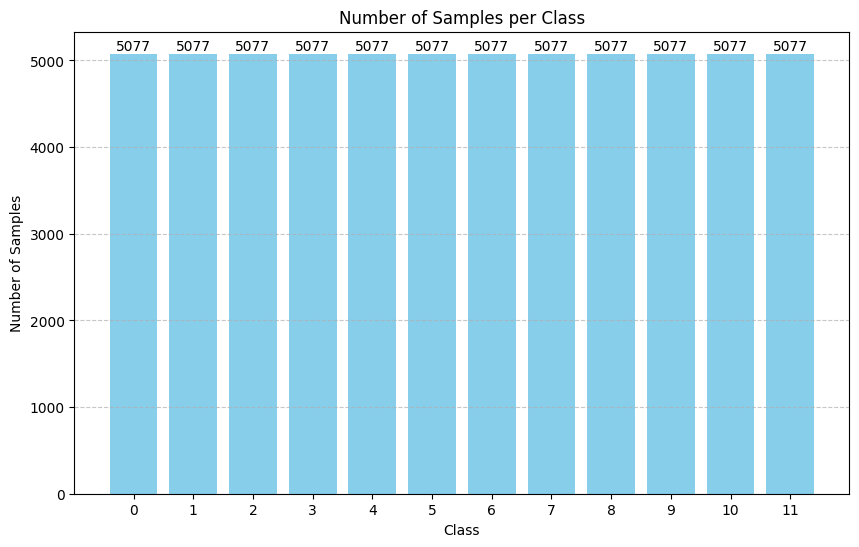

In [ ]:
# Get unique labels and their counts
unique_classes, counts = np.unique(balanced_y_text, return_counts=True)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(unique_classes)  # Ensure all classes are labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, count,
             ha='center', va='bottom')

plt.show()

In [ ]:
train_size = int(0.6 * len(balanced_x_text))
validation_size = int(0.1 * len(balanced_x_text))

train_x_text = balanced_x_text[:train_size]
train_y_text = balanced_y_text[:train_size]

validation_x_text = balanced_x_text[train_size: train_size + validation_size]
validation_y_text = balanced_y_text[train_size: train_size + validation_size]

test_x_text = balanced_x_text[train_size + validation_size:]
test_y_text = balanced_y_text[train_size + validation_size:]

print("Train X shape:", train_x_text.shape)
print("Train Y shape:", train_y_text.shape)
print("Validation X shape:", validation_x_text.shape)
print("Validation Y shape:", validation_y_text.shape)
print("Test X shape:", test_x_text.shape)
print("Test Y shape:", test_y_text.shape)

Train X shape: (36554, 100)
Train Y shape: (36554,)
Validation X shape: (6092, 100)
Validation Y shape: (6092,)
Test X shape: (18278, 100)
Test Y shape: (18278,)


In [ ]:
# PCA Dataset

# Number of principal components to retain
n_components = 20

# Create PCA object
pca = PCA(n_components=n_components)

# Train
TRAIN_SIZE = -1

pca.fit(train_x_text[:TRAIN_SIZE])
train_x_PCA_text = pca.transform(train_x_text[:TRAIN_SIZE])
train_y_PCA_text = train_y_text[:TRAIN_SIZE].copy()

# Validation
VALIDATION_SIZE = -1

validation_x_PCA_text = pca.transform(validation_x_text[:TRAIN_SIZE])
validation_y_PCA_text = validation_y_text[:VALIDATION_SIZE].copy()

# Test

TEST_SIZE = -1

test_x_PCA_text = pca.transform(test_x_text[:TEST_SIZE])
test_y_PCA_text = test_y_text[:TEST_SIZE].copy()

Explained variance:  42.771


### **MLP**

##### Training

In [ ]:
MLP_network_text  = [
    Dense(20,256),
    LeakyReLU(),
    Dense(256,128),
    LeakyReLU(),
    Dense_Softmax(128,12)
]

# Instantiate the Model object
MLP_text = Model(MLP_network_text)

MLP_text.summary()

Layer (name)          | Input Shape           | Output Shape         | Trainable Parameters
-------------------------------------------------------------------------------------------
        Dense         |          20          ->         256          |       (5,376)        
      LeakyReLU       |         None         ->         None         |           -          
        Dense         |         256          ->         128          |       (32,896)       
      LeakyReLU       |         None         ->         None         |           -          
    Dense_softmax     |         128          ->          12          |       (1,548)        
-------------------------------------------------------------------------------------------
Total Trainable Parameters: 39,820


In [ ]:
# Train the model

MLP_text.fit(train_x_PCA_text, train_y_PCA_text, validation_data = (validation_x_PCA_text, validation_y_PCA_text), epochs=10, batch_size = 32, learning_rate = 0.01, loss_type = 'cross_entropy')

Epoch : 1 Batch : 1142/1142 Training Loss 2.289 | Training Accuracy: 18.75% | Validation Loss 2.339 | Validation Accuracy : 15.81%
Epoch : 2 Batch : 1142/1142 Training Loss 2.098 | Training Accuracy: 34.38% | Validation Loss 2.319 | Validation Accuracy : 17.07%
Epoch : 3 Batch : 1142/1142 Training Loss 1.985 | Training Accuracy: 25.00% | Validation Loss 2.259 | Validation Accuracy : 21.38%
Epoch : 4 Batch : 1142/1142 Training Loss 2.403 | Training Accuracy: 15.62% | Validation Loss 2.250 | Validation Accuracy : 20.55%
Epoch : 5 Batch : 1142/1142 Training Loss 2.274 | Training Accuracy: 15.62% | Validation Loss 2.242 | Validation Accuracy : 21.15%
Epoch : 6 Batch : 1142/1142 Training Loss 2.131 | Training Accuracy: 37.50% | Validation Loss 2.235 | Validation Accuracy : 20.52%
Epoch : 7 Batch : 1142/1142 Training Loss 2.166 | Training Accuracy: 21.88% | Validation Loss 2.230 | Validation Accuracy : 20.97%
Epoch : 8 Batch : 1142/1142 Training Loss 2.169 | Training Accuracy: 28.12% | Valid

In [ ]:
MLP_text.save_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/MLP/MLP_PCA_Text_10_epochs_balanced_dataset.pkl')

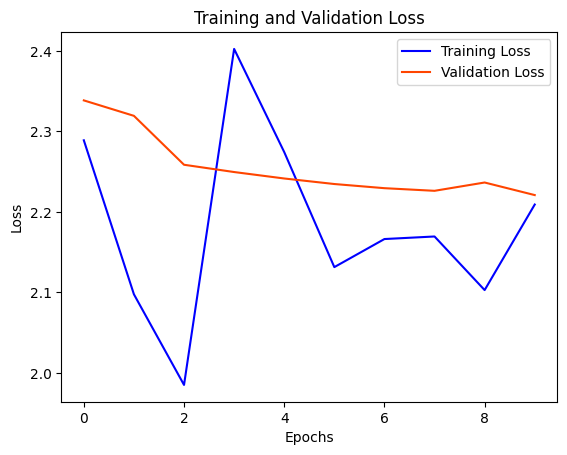

In [ ]:
# Plot the losses

plt.plot(MLP_text.Training_loss_list, 'b', label='Training Loss')
plt.plot(MLP_text.Validation_loss_list, 'orangered', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Testing

In [ ]:
network = []

# Instantiate the Model object
MLP_loaded = Model(network)
MLP_loaded = MLP_loaded.load_model('/content/drive/MyDrive/E1 213 Pattern Recognition and Neural Networks Assignments/Assignment - 03/Models/MLP/MLP_PCA_Text_10_epochs_balanced_dataset.pkl')

In [ ]:
# Training Accuracy

y_pred_train = MLP_loaded.predict(train_x_PCA_text)

print(f'Training Accuracy of MLP on Text Dataset : {accuracy(y_pred_train, train_y_PCA_text)*100:.2f} %')
print(f'Training F1 Score of MLP on Text Dataset : {f1_score(y_pred_train, train_y_PCA_text):.3f}')

Training Accuracy of MLP on Text Dataset : 21.74 %
Training F1 Score of MLP on Text Dataset : 0.213


In [ ]:
# Testing Accuracy

y_pred_test = MLP_loaded.predict(test_x_PCA_text)

print(f'Testing Accuracy of MLP on Text Dataset : {accuracy(y_pred_test, test_y_PCA_text)*100:.2f} %')
print(f'Testing F1 Score of MLP on Text Dataset : {f1_score(y_pred_test, test_y_PCA_text):.3f}')

Testing Accuracy of MLP on Text Dataset : 21.44 %
Testing F1 Score of MLP on Text Dataset : 0.232


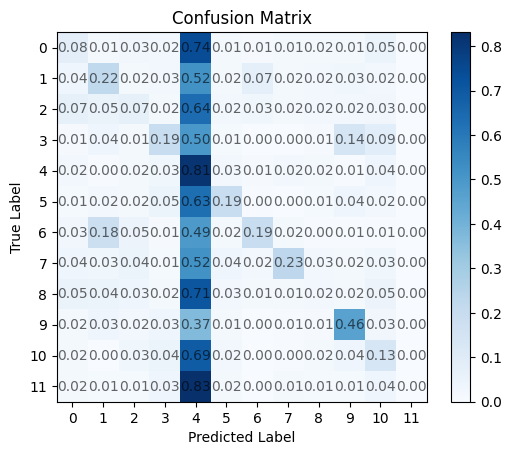

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_text, y_pred_test))

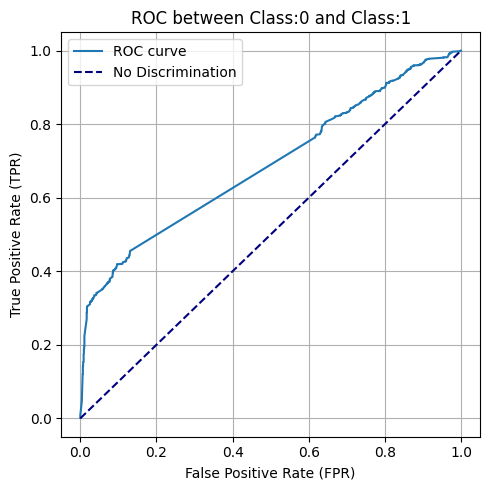

In [ ]:
plot_ROC(test_y_PCA_text, y_pred_test,0,1)

### **Decision Tree**


Loss - Gini

In [ ]:
DT = DecisionTree(max_depth=5, criterion='gini')

# Fit the tree to the training data
DT.fit(train_x_PCA_text, train_y_PCA_text)

In [ ]:
# Training Accuracy

y_pred_train = DT.predict(train_x_PCA_text)

print(f'Training Accuracy of MLP on Text Dataset : {accuracy(y_pred_train, train_y_PCA_text)*100:.2f} %')
print(f'Training F1 Score of MLP on Text Dataset : {f1_score(y_pred_train, train_y_PCA_text):.3f}')

Training Accuracy of MLP on Text Dataset : 18.99 %
Training F1 Score of MLP on Text Dataset : 0.187


In [ ]:
# Testing Accuracy

y_pred_test = DT.predict(test_x_PCA_text)

print(f'Testing Accuracy of MLP on Text Dataset : {accuracy(y_pred_test, test_y_PCA_text)*100:.2f} %')
print(f'Testing F1 Score of MLP on Text Dataset : {f1_score(y_pred_test, test_y_PCA_text):.3f}')

Testing Accuracy of MLP on Text Dataset : 19.06 %
Testing F1 Score of MLP on Text Dataset : 0.190


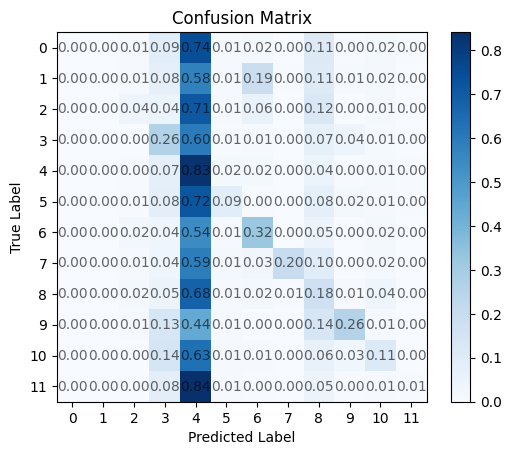

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_text, y_pred_test))

Loss - Entropy

In [ ]:
DT = DecisionTree(max_depth=5, criterion='entropy')

# Fit the tree to the training data
DT.fit(train_x_PCA_text, train_y_PCA_text)

In [ ]:
# Training Accuracy

y_pred_train = DT.predict(train_x_PCA_text)

print(f'Training Accuracy of MLP on Text Dataset : {accuracy(y_pred_train, train_y_PCA_text)*100:.2f} %')
print(f'Training F1 Score of MLP on Text Dataset : {f1_score(y_pred_train, train_y_PCA_text):.3f}')

Training Accuracy of MLP on Text Dataset : 21.71 %
Training F1 Score of MLP on Text Dataset : 0.240


In [ ]:
# Testing Accuracy

y_pred_test = DT.predict(test_x_PCA_text)

print(f'Testing Accuracy of MLP on Text Dataset : {accuracy(y_pred_test, test_y_PCA_text)*100:.2f} %')
print(f'Testing F1 Score of MLP on Text Dataset : {f1_score(y_pred_test, test_y_PCA_text):.3f}')

Testing Accuracy of MLP on Text Dataset : 21.12 %
Testing F1 Score of MLP on Text Dataset : 0.233


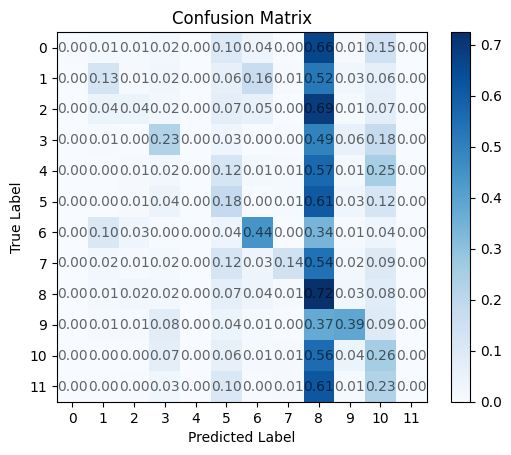

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_text, y_pred_test))

### **Random Forest**

In [ ]:
num_tree = 9

RF = RandomForest(num_trees = num_tree, max_depth = 5, criterion = 'gini')

# Fit the tree to the training data
RF.fit(train_x_PCA_text, train_y_PCA_text)

Tree 1 fitted!
Tree 2 fitted!
Tree 3 fitted!
Tree 4 fitted!
Tree 5 fitted!
Tree 6 fitted!
Tree 7 fitted!
Tree 8 fitted!
Tree 9 fitted!


In [ ]:
# Training Accuracy

y_pred_train = RF.predict(train_x_PCA_text)

print(f'Training Accuracy of RF (No. of trees = {num_tree}) on Text Dataset : {accuracy(y_pred_train, train_y_PCA_text)*100:.2f} %')
print(f'Training F1 Score of RF (No. of trees = {num_tree}) on Text Dataset : {f1_score(y_pred_train, train_y_PCA_text):.3f}')

Training Accuracy of RF (No. of trees = 9) on Text Dataset : 22.32 %
Training F1 Score of RF (No. of trees = 9) on Text Dataset : 0.237


In [ ]:
# Testing Accuracy

y_pred_test = RF.predict(test_x_PCA_text)

print(f'Testing Accuracy of RF (No. of trees = {num_tree}) on Text Dataset : {accuracy(y_pred_test, test_y_PCA_text)*100:.2f} %')
print(f'Testing F1 Score of RF (No. of trees = {num_tree}) on Text Dataset : {f1_score(y_pred_test, test_y_PCA_text):.3f}')

Testing Accuracy of RF (No. of trees = 9) on Text Dataset : 22.55 %
Testing F1 Score of RF (No. of trees = 9) on Text Dataset : 0.240


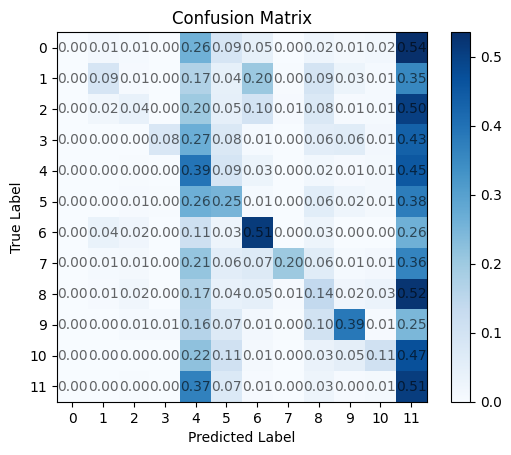

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_text, y_pred_test))

Tree Depth 5


| No. of trees | Training Accuracy | Training F1 Score | Testing Accuracy | Testing F1 Score |
|--------------|-------------------|-------------------|------------------|------------------|
| 3            | 21.36%            | 0.238             | 21.03%           | 0.212            |
| 5            | 21.58%            | 0.239             | 21.52%           | 0.267            |
| 7            | 22.15%            | 0.210             | 22.21%           | 0.217            |
| 9            | 22.32%            | 0.237             | 22.55%           | 0.240            |

This table represents the training and testing accuracy, as well as the F1 score, for Random Forest models with different numbers of trees on a text dataset.

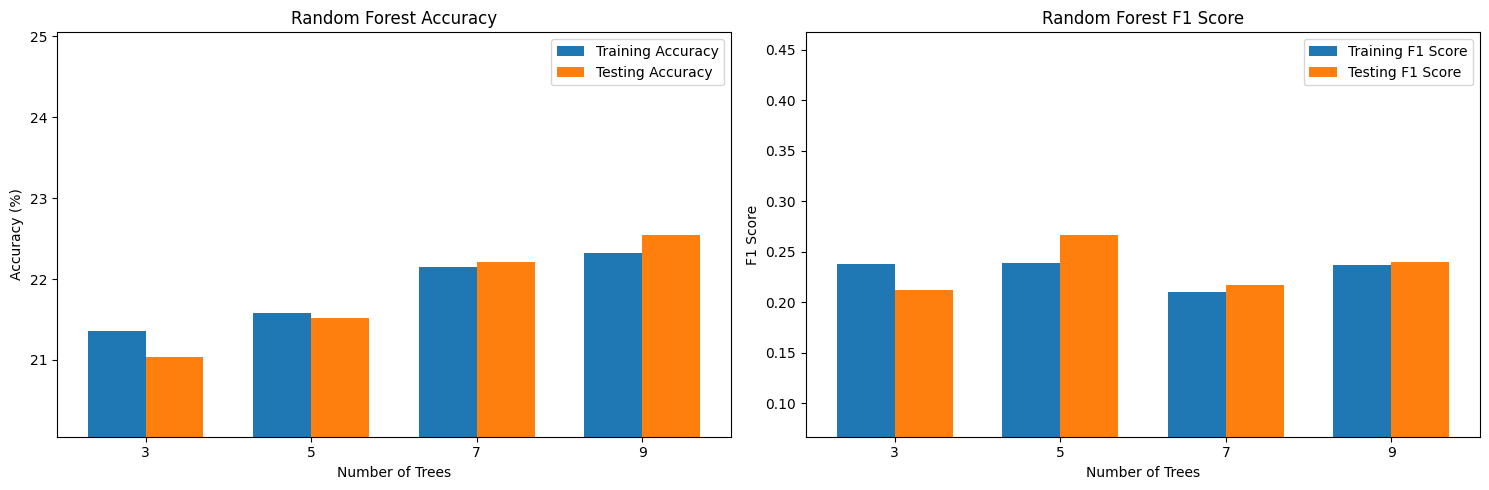

In [ ]:
# Data
no_of_trees = [3, 5, 7, 9]
training_accuracy = [21.36, 21.58, 22.15, 22.32]
testing_accuracy = [21.03, 21.52, 22.21, 22.55]
training_f1 = [0.238, 0.239, 0.210, 0.237]
testing_f1 = [0.212, 0.267, 0.217, 0.240]

# Get maximum values
max_accuracy = max(max(training_accuracy), max(testing_accuracy))
max_f1 = max(max(training_f1), max(testing_f1))

# Plotting
plt.figure(figsize=(15, 5))

# Accuracy
plt.subplot(1, 2, 1)
bar_width = 0.35
index = range(len(no_of_trees))
plt.bar(index, training_accuracy, bar_width, label='Training Accuracy')
plt.bar([i + bar_width for i in index], testing_accuracy, bar_width, label='Testing Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy (%)')
plt.title('Random Forest Accuracy')
plt.xticks([i + bar_width/2 for i in index], no_of_trees)
plt.ylim(max(0, max_accuracy - 2.5), max_accuracy + 2.5)
plt.legend()

# F1 Score
plt.subplot(1, 2, 2)
plt.bar(index, training_f1, bar_width, label='Training F1 Score')
plt.bar([i + bar_width for i in index], testing_f1, bar_width, label='Testing F1 Score')
plt.xlabel('Number of Trees')
plt.ylabel('F1 Score')
plt.title('Random Forest F1 Score')
plt.xticks([i + bar_width/2 for i in index], no_of_trees)
plt.ylim(max(0, max_f1 - 0.2), max_f1 + 0.2)
plt.legend()

plt.tight_layout()
plt.show()


### **XGBoost**

In [ ]:
n_estimators = 50
xgboost = XGBoost(n_estimators=n_estimators, learning_rate=1, max_depth=5, criterion='gini')
xgboost.fit(train_x_PCA_text[:2000], train_y_PCA_text[:2000])

Learners fit 1
Learners fit 2
Learners fit 3
Learners fit 4
Learners fit 5
Learners fit 6
Learners fit 7
Learners fit 8
Learners fit 9
Learners fit 10
Learners fit 11
Learners fit 12
Learners fit 13
Learners fit 14
Learners fit 15
Learners fit 16
Learners fit 17
Learners fit 18
Learners fit 19
Learners fit 20
Learners fit 21
Learners fit 22
Learners fit 23
Learners fit 24
Learners fit 25
Learners fit 26
Learners fit 27
Learners fit 28
Learners fit 29
Learners fit 30
Learners fit 31
Learners fit 32
Learners fit 33
Learners fit 34
Learners fit 35
Learners fit 36
Learners fit 37
Learners fit 38
Learners fit 39
Learners fit 40
Learners fit 41
Learners fit 42
Learners fit 43
Learners fit 44
Learners fit 45
Learners fit 46
Learners fit 47
Learners fit 48
Learners fit 49
Learners fit 50


In [ ]:
# Training Accuracy

y_pred_train = xgboost.predict(train_x_PCA_text)

print(f'Training Accuracy of XGBT (no. of steps = {n_estimators}) on Text Dataset : {accuracy(y_pred_train, train_y_PCA_text)*100:.2f} %')
print(f'Training F1 Score of XGBT (no. of steps = {n_estimators}) on Text Dataset : {f1_score(y_pred_train, train_y_PCA_text):.3f}')

Training Accuracy of XGBT (no. of steps = 50) on Text Dataset : 22.74 %
Training F1 Score of XGBT (no. of steps = 50) on Text Dataset : 0.232


In [ ]:
# Testing Accuracy
y_pred_test = xgboost.predict(test_x_PCA_text)

print(f'Testing Accuracy of XGBT (no. of steps = {n_estimators}) on Text Dataset : {accuracy(y_pred_test, test_y_PCA_text)*100:.2f} %')
print(f'Testing F1 Score of XGBT (no. of steps = {n_estimators}) on Text Dataset : {f1_score(y_pred_test, test_y_PCA_text):.3f}')

Testing Accuracy of XGBT (no. of steps = 50) on Text Dataset : 22.48 %
Testing F1 Score of XGBT (no. of steps = 50) on Text Dataset : 0.226


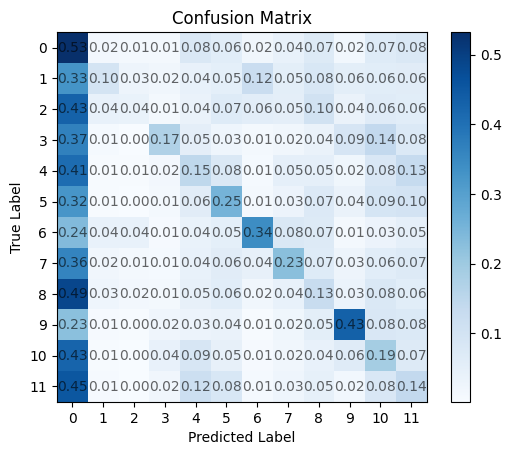

In [ ]:
confusion_matrix_heatmap(confusion_matrix(test_y_PCA_text, y_pred_test))

| No. of Steps | Training Accuracy | Training F1 Score | Testing Accuracy | Testing F1 Score |
|--------------|-------------------|-------------------|------------------|------------------|
| 10           | 20.68%            | 0.199             | 20.25%           | 0.192            |
| 20           | 20.48%            | 0.206             | 20.32%           | 0.200            |
| 30           | 21.64%            | 0.213             | 20.88%           | 0.203            |
| 40           | 21.45%            | 0.215             | 21.14%           | 0.209            |
| 50           | 22.74%            | 0.232             | 22.48%           | 0.226            |


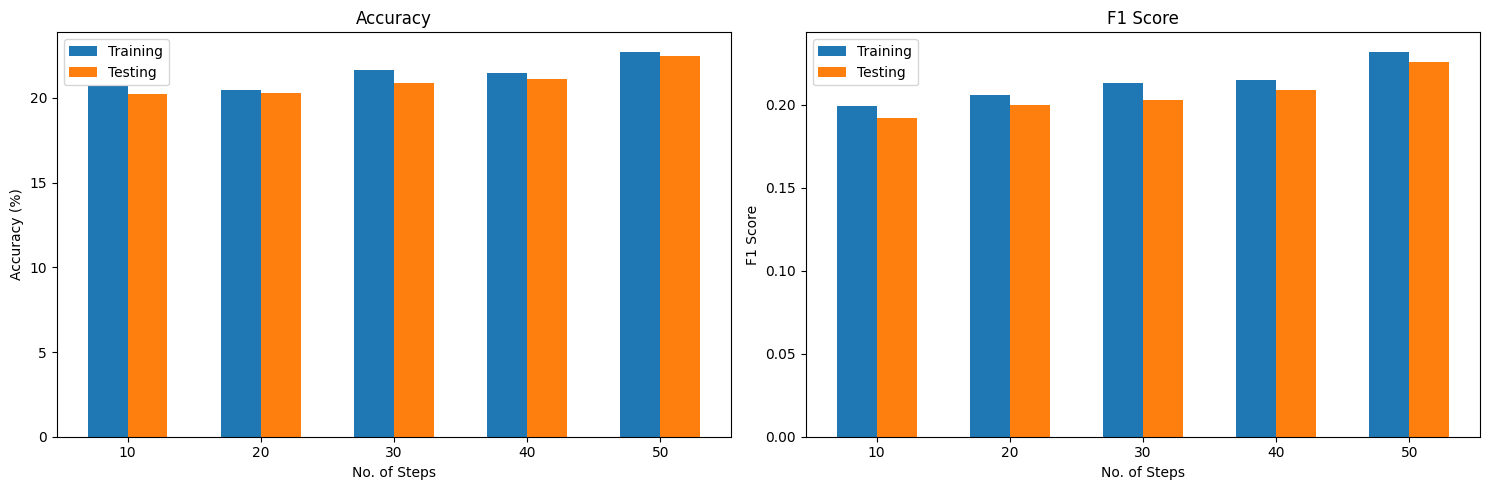

In [ ]:
# Data
no_of_steps = [10, 20, 30, 40, 50]
training_accuracy = [20.68, 20.48, 21.64, 21.45, 22.74]
testing_accuracy = [20.25, 20.32, 20.88, 21.14, 22.48]
training_f1_score = [0.199, 0.206, 0.213, 0.215, 0.232]
testing_f1_score = [0.192, 0.200, 0.203, 0.209, 0.226]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axs[0].bar(no_of_steps, training_accuracy, width=3, label='Training')
axs[0].bar([x + 3 for x in no_of_steps], testing_accuracy, width=3, label='Testing')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('No. of Steps')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_xticks([x + 1.5 for x in no_of_steps])
axs[0].set_xticklabels(no_of_steps)
axs[0].legend()

# F1 Score
axs[1].bar(no_of_steps, training_f1_score, width=3, label='Training')
axs[1].bar([x + 3 for x in no_of_steps], testing_f1_score, width=3, label='Testing')
axs[1].set_title('F1 Score')
axs[1].set_xlabel('No. of Steps')
axs[1].set_ylabel('F1 Score')
axs[1].set_xticks([x + 1.5 for x in no_of_steps])
axs[1].set_xticklabels(no_of_steps)
axs[1].legend()

plt.tight_layout()
plt.show()


### **Results Comparison**

| Model                                | Testing Accuracy | Testing F1 Score |
|--------------------------------------|------------------|------------------|
| MLP                                  | 21.44%           | 0.232            |
| Decision Tree (Gini)                | 19.06%           | 0.190            |
| Decision Tree (Entropy)             | 21.12%           | 0.233            |
| Random Forest                        | 22.55%           | 0.240            |
| XGBoost                              | 22.48%           | 0.226            |
| Self Attention (with tf-idf)         | 8.09%            | 0.072            |
| Self Attention (with word2vec)         | 25.5%            | 0.244            |

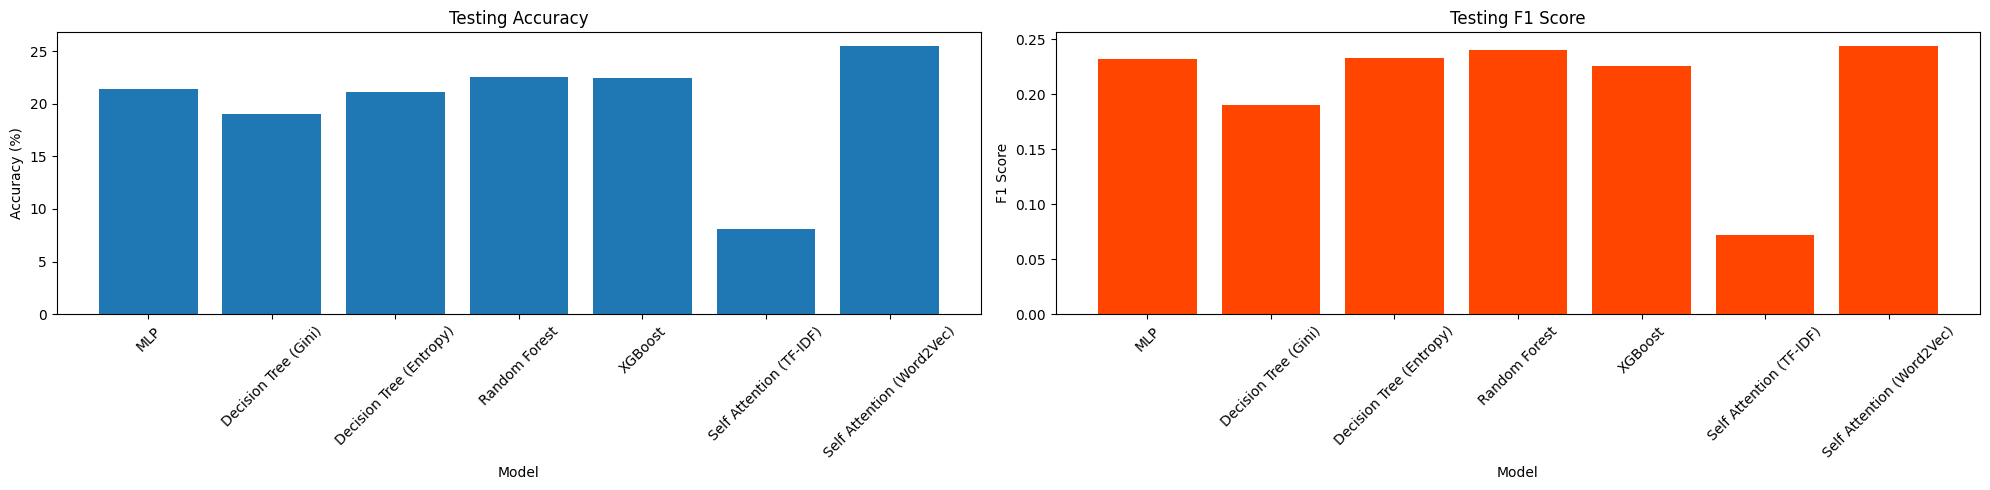

In [ ]:
# Data
models = ['MLP', 'Decision Tree (Gini)', 'Decision Tree (Entropy)', 'Random Forest', 'XGBoost', 'Self Attention (TF-IDF)', 'Self Attention (Word2Vec)']
accuracies = [21.44, 19.06, 21.12, 22.55, 22.48, 8.09,25.5]
f1_scores = [0.232, 0.190, 0.233, 0.240, 0.226, 0.072,0.244]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plotting accuracy
axs[0].bar(models, accuracies)
axs[0].set_title('Testing Accuracy')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Accuracy (%)')
axs[0].tick_params(axis='x', rotation=45)

# Plotting F1 score
axs[1].bar(models, f1_scores, color='orangered')
axs[1].set_title('Testing F1 Score')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('F1 Score')
axs[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## **Implementing Self Attention**:

#### **Data loading and Preprocessing (Image):**

##### **Loading:**

In [ ]:
def load_dataset(directory, image_size=(96, 96)):
    data = []
    labels = []
    label_mapping = {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
    label_count = {'cane': 0, 'cavallo': 0, 'elefante': 0, 'farfalla': 0, 'gallina': 0, 'gatto': 0, 'mucca': 0, 'pecora': 0, 'ragno': 0, 'scoiattolo': 0}
    min_label_count = 1446
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith((".jpg", ".png", ".jpeg")):
                image_path = os.path.join(root, file)
                label = os.path.basename(os.path.normpath(root))
                if label in label_mapping:
                  if  label_count[label]<min_label_count:
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, image_size)
                    data.append(image)
                    labels.append(label_mapping[label])
                    label_count[label]+=1

    data = np.array(data, dtype=np.float32) / 255.0 - 0.5
    labels = np.array(labels)

    return data, labels

In [ ]:
def split_dataset(data, labels, train_ratio=0.6, validation_ratio=0.1, seed=42):
    rng = np.random.RandomState(seed)
    permutation = rng.permutation(len(data))
    data = data[permutation]
    labels = labels[permutation]

    num_samples = len(data)
    train_size = int(num_samples * train_ratio)
    validation_size = int(num_samples * validation_ratio)

    x_train, y_train = data[:train_size], labels[:train_size]
    x_validation, y_validation = data[train_size:train_size + validation_size], labels[train_size:train_size + validation_size]
    x_test, y_test = data[train_size + validation_size:], labels[train_size + validation_size:]

    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [ ]:
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/E1 213 Pattern Recognition and Neural Network/Assignment_03/archive.zip'
extract_dir = '/content/dataset'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for member in tqdm(zip_ref.infolist(), desc='Extracting files'):
        zip_ref.extract(member, extract_dir)

data_dir = '/content/dataset'
data, labels = load_dataset(data_dir)

x_train, y_train, x_validation, y_validation, x_test, y_test = split_dataset(data, labels)

print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_validation: ", x_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Extracting files: 100%|██████████| 26180/26180 [00:21<00:00, 1221.77it/s]


Shape of x_train:  (8676, 96, 96, 3)
Shape of y_train:  (8676,)
Shape of x_validation:  (1446, 96, 96, 3)
Shape of y_validation:  (1446,)
Shape of x_test:  (4338, 96, 96, 3)
Shape of y_test:  (4338,)


Number of images in class dog: 1446
Number of images in class horse: 1446
Number of images in class elephant: 1446
Number of images in class butterfly: 1446
Number of images in class chicken: 1446
Number of images in class cat: 1446
Number of images in class cow: 1446
Number of images in class sheep: 1446
Number of images in class spider: 1446
Number of images in class squirrel: 1446


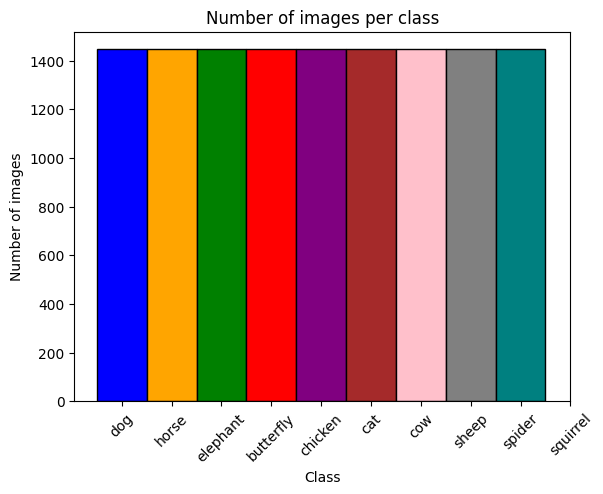

In [ ]:
# Define your class names
class_names = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

# Define a list of colors for each class
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'teal']

# Assuming 'labels' is your list of labels
n, bins, patches = plt.hist(labels, bins=np.arange(len(class_names))-0.5, edgecolor='black')

# Assuming 'labels' is your list of labels
class_counts = np.bincount(labels)

# Print the number of images for each class
for i, count in enumerate(class_counts):
    print(f'Number of images in class {class_names[i]}: {count}')

# Set the color of each bar according to the colors list
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i % len(colors)])

plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images per class')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.show()

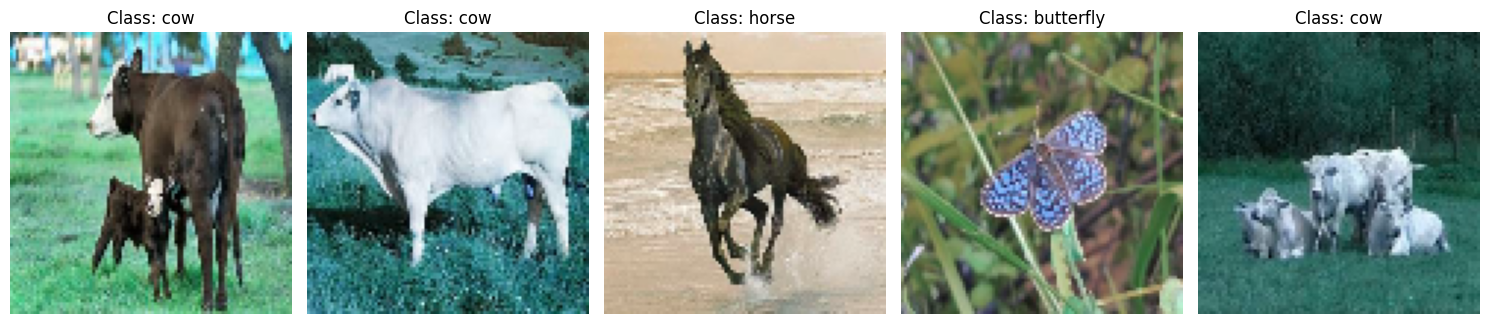

In [ ]:
# Define your class names
class_names = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

# Display 5 random images with their corresponding class labels
num_images_to_show = 5
fig, axs = plt.subplots(1, num_images_to_show, figsize=(15, 15))

random_indices = random.sample(range(len(x_train)), num_images_to_show)

for i, idx in enumerate(random_indices):
    image = (x_train[idx] + 0.5).astype('float')
    label = y_train[idx]
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Class: {class_names[label]}')

plt.tight_layout()
plt.show()


In [ ]:
limit = 10000

X_train = x_train[:limit]
Y_train = y_train[:limit]
X_validation= x_validation[:limit]
Y_validation= y_validation[:limit]
X_test =  x_test[:limit]
Y_test = y_test[:limit]

##### **Image Tokenisation, PCA , Positional Encoding**

###### Implementing Image Tokenization:

In [ ]:
# Implementing Image Tokenisation:
def image_tokenization(images, patch_size):
    num_images, image_height, image_width, channels = images.shape

    # Initialize an array to store the flattened patches
    patches_dataset = []

    # Extract patches for each image
    for i in range(num_images):
        image = images[i]
        patches_image = []
        for h in range(0, image_height-patch_size+1, patch_size):
            for w in range(0, image_width-patch_size+1, patch_size):
                # Define patch
                patch = image[h:h+patch_size, w:w+patch_size, :].copy().reshape(-1)
                patches_image.append(patch)

        patches_dataset.append(patches_image)
    return np.array(patches_dataset)

patch_size = 8
# Tokenization of training data
X_train_tokenized = image_tokenization(X_train, patch_size)
print(f"Training data has been tokenized. Size of tokenized training data: {X_train_tokenized.shape}")

# Tokenization of validation data
X_validation_tokenized = image_tokenization(X_validation, patch_size)
print(f"Validation data has been tokenized. Size of tokenized validation data: {X_validation_tokenized.shape}")

# Tokenization of testing data
X_test_tokenized = image_tokenization(X_test, patch_size)
print(f"Testing data has been tokenized. Size of tokenized testing data: {X_test_tokenized.shape}")


Training data has been tokenized. Size of tokenized training data: (8676, 144, 192)
Validation data has been tokenized. Size of tokenized validation data: (1446, 144, 192)
Testing data has been tokenized. Size of tokenized testing data: (4338, 144, 192)


###### Implementing PCA:

In [ ]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.principal_components_ = None
        self.explained_variance_ratio_ = None

    def fit(self, data):
        n_images, n_patches, n_features = data.shape
        transformed_data = np.zeros((n_images, n_patches, self.n_components))
        explained_variance_ratios = []

        for i in range(n_images):
            # Step 1: Subtract the mean from the data
            image_data = data[i]
            data_mean = np.mean(image_data, axis=0)
            data_centered = image_data - data_mean

            # Step 2: Compute the covariance matrix
            cov_matrix = np.cov(data_centered.T)

            # Step 3: Compute the eigenvalues and eigenvectors of the covariance matrix
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

            # Step 4: Sort the eigenvalues and eigenvectors in descending order
            sorted_indices = np.argsort(eigenvalues)[::-1]
            sorted_eigenvalues = eigenvalues[sorted_indices]
            sorted_eigenvectors = eigenvectors[:, sorted_indices]

            # Step 5: Select the top n_components eigenvectors
            principal_components = sorted_eigenvectors[:, :self.n_components]
            self.principal_components_ = principal_components

            # Step 6: Project the data onto the principal components
            transformed_data[i] = np.dot(data_centered, principal_components)

            # Calculate the explained variance ratio for this image
            total_variance = np.sum(eigenvalues)
            explained_variance = np.sum(sorted_eigenvalues[:self.n_components])
            explained_variance_ratio = explained_variance / total_variance
            explained_variance_ratios.append(explained_variance_ratio)
            #print(f"Image {i}, explained variance {explained_variance_ratio}")
        # Calculate the average explained variance ratio across all images
        self.explained_variance_ratio_ = np.mean(explained_variance_ratios)

        return transformed_data

    def transform(self, data):
        n_images, n_patches, n_features = data.shape
        transformed_data = np.zeros((n_images, n_patches, self.n_components))

        for i in range(n_images):
            image_data = data[i]
            data_mean = np.mean(image_data, axis=0)
            data_centered = image_data - data_mean

            transformed_data[i] = np.dot(data_centered, self.principal_components_)

        return transformed_data

In [ ]:
n_components = 64  # Number of principal components

pca = PCA(n_components)
X_train_PCA = pca.fit(X_train_tokenized)

print(f"Transformed train data shape: {X_train_PCA.shape}")
print(f"Average explained variance ratio: {pca.explained_variance_ratio_:.4f}")

# Transform validation and test data:
X_validation_PCA = pca.transform(X_validation_tokenized)
print(f"Validation data shape: {X_validation_PCA.shape}")

X_test_PCA = pca.transform(X_test_tokenized)
print(f"Test data shape: {X_test_PCA.shape}")

<ipython-input-10-509584511218>:39: RuntimeWarning: invalid value encountered in scalar divide
  explained_variance_ratio = explained_variance / total_variance


Transformed train data shape: (8676, 144, 64)
Average explained variance ratio: nan
Validation data shape: (1446, 144, 64)
Test data shape: (4338, 144, 64)


###### Implementing Positional Encoding:

In [ ]:
def positional_encoding(data, max_length):
    n_images, n_patches, n_features = data.shape
    encoded_data = np.zeros_like(data)

    for i in range(n_images):
        for j in range(n_patches):
            position = np.arange(n_features)
            freqs = 1 / (10000 ** (2 * np.arange(n_features // 2) / n_features))

            sin_encoding = np.sin(position[:n_features // 2] * freqs)
            cos_encoding = np.cos(position[n_features // 2:] * freqs)

            encoding = np.concatenate([sin_encoding, cos_encoding], axis=0)
            encoded_data[i, j] = data[i, j] + encoding

    return encoded_data

In [ ]:
max_length = n_components # Maximum length of the positional encoding sequence

X_train_encoded = positional_encoding(X_train_PCA, max_length)
print(f"Encoded training data shape: {X_train_encoded.shape}")

X_validation_encoded = positional_encoding(X_validation_PCA, max_length)
print(f"Encoded validation data shape: {X_validation_encoded.shape}")

X_test_encoded = positional_encoding(X_test_PCA, max_length)
print(f"Encoded test data shape: {X_test_encoded.shape}")

Encoded training data shape: (8676, 144, 64)
Encoded validation data shape: (1446, 144, 64)
Encoded test data shape: (4338, 144, 64)


#### **Data Loading and preprocessing (Text):**

##### **Loading:**

In [ ]:
text_df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/E1 213 Pattern Recognition and Neural Network/Assignment_03/News_Category_Dataset_v3.json', lines=True)
columns = ['headline', 'category']
text_df = text_df[columns]
text_df.head()

# Count the occurrences of each category
category_counts = text_df['category'].value_counts()

# Select the top 12 categories by occurrences
top_categories = category_counts.head(12).index.tolist()

# Filter the dataframe to keep only the rows with top categories
filtered_df = text_df[text_df['category'].isin(top_categories)]

# One-hot encode the categories
one_hot_encoded = pd.get_dummies(filtered_df['category'])
labels = np.argmax(one_hot_encoded.to_numpy().astype('int'),axis = 1)

x_text = filtered_df['headline'].copy()
y_text = labels.copy()

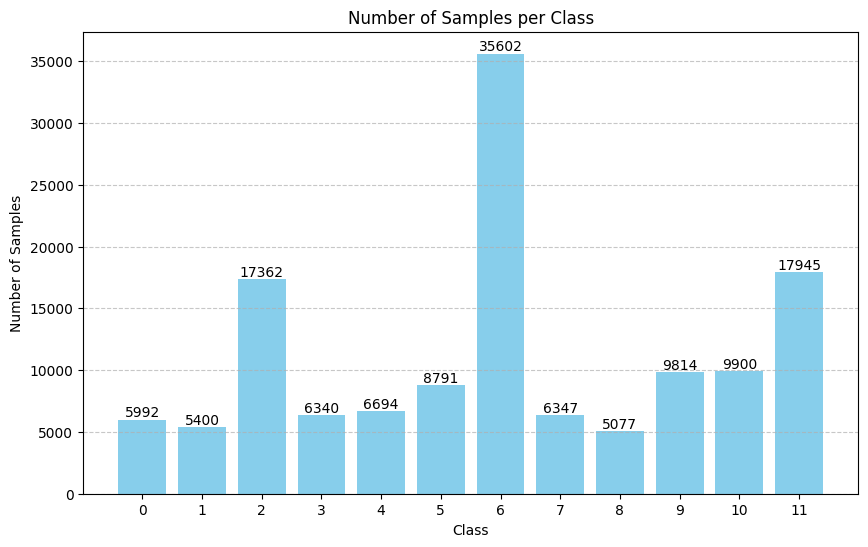

In [ ]:
# Get unique labels and their counts
unique_classes, counts = np.unique(y_text, return_counts=True)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(unique_classes)  # Ensure all classes are labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, count,
             ha='center', va='bottom')

plt.show()

In [ ]:
# Determine the minimum number of samples among all classes
min_samples = np.min(np.bincount(y_text))

# Initialize lists to store balanced subsets
balanced_x_text = pd.Series(dtype=object)
balanced_y_text = pd.Series(dtype=int)

# Select a subset of samples from each class
for label in np.unique(y_text):
    # Get indices of samples with current label
    indices = np.where(y_text == label)[0]

    # Select the first min_samples indices
    selected_indices = indices[:min_samples]

    # Append selected samples to balanced dataset
    balanced_x_text = pd.concat([balanced_x_text, x_text.iloc[selected_indices]])
    balanced_y_text = pd.concat([balanced_y_text, pd.Series([label]*min_samples)])

# Reset the indices
balanced_x_text.reset_index(drop=True, inplace=True)
balanced_y_text.reset_index(drop=True, inplace=True)


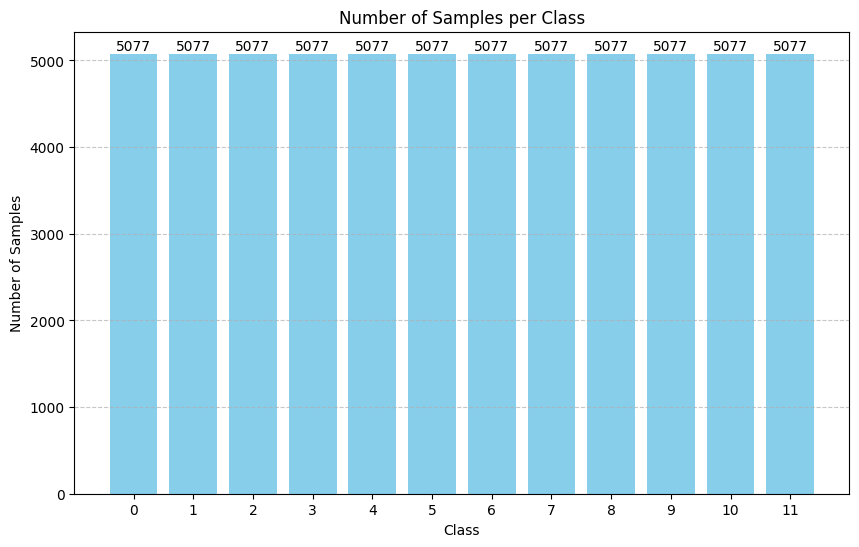

In [ ]:
# Get unique labels and their counts
unique_classes, counts = np.unique(balanced_y_text, return_counts=True)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.xticks(unique_classes)  # Ensure all classes are labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, count,
             ha='center', va='bottom')

plt.show()

##### **Using Tf-idf Embedding:**

In [ ]:
token_length = 1

def custom_tokenizer(text, token_length):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and consider token length
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) >= token_length]

    return tokens

vectorizer = TfidfVectorizer(tokenizer=lambda text: custom_tokenizer(text, token_length=1), max_features=100)
tfidf_matrix = vectorizer.fit_transform(balanced_x_text)
X_dataset_embedded = tfidf_matrix.toarray()
x_text_final = np.reshape(X_dataset_embedded, (X_dataset_embedded.shape[0], X_dataset_embedded.shape[1], 1))

In [ ]:
# Shuffle the balanced dataset
shuffled_indices = np.arange(len(x_text_final))
np.random.shuffle(shuffled_indices)
X_dataset = x_text_final[shuffled_indices]
Y_dataset = balanced_y_text[shuffled_indices]

train_size = int(0.6 * len(X_dataset))
validation_size = int(0.1 * len(X_dataset))

train_x_text = X_dataset[:train_size]
train_y_text = Y_dataset[:train_size]

validation_x_text = X_dataset[train_size: train_size + validation_size]
validation_y_text = Y_dataset[train_size: train_size + validation_size]

test_x_text = X_dataset[train_size + validation_size:]
test_y_text = Y_dataset[train_size + validation_size:]

print("Train X shape:", train_x_text.shape)
print("Train Y shape:", train_y_text.shape)
print("Validation X shape:", validation_x_text.shape)
print("Validation Y shape:", validation_y_text.shape)
print("Test X shape:", test_x_text.shape)
print("Test Y shape:", test_y_text.shape)

##### **Using Word2Vec Embedding:**

In [ ]:
def remove_punctuation(input_string):
    # Make a regular expression object that matches any punctuation
    regex = re.compile('[^a-zA-Z0-9\s]')

    # Substitute all punctuation with an empty string
    cleaned_string = regex.sub('', input_string)

    return cleaned_string

x_text_cleaned = balanced_x_text.apply(remove_punctuation)

def tokenize_text(input_string):
    # Tokenize the input string
    tokenized_string = word_tokenize(input_string)

    return tokenized_string

x_text_tokenized = x_text_cleaned.apply(tokenize_text)

# Train a Word2Vec model on your tokenized texts
model = Word2Vec(sentences=x_text_tokenized.tolist(), vector_size=100, window=5, min_count=1, workers=4)

# Function to convert a list of tokens to a list of embeddings
def tokens_to_embeddings(tokens):
    embeddings = [model.wv[token] for token in tokens]
    return embeddings

x_text_embeddings = x_text_tokenized.apply(tokens_to_embeddings)


# Determine the maximum number of tokens in the texts
max_tokens = max(x_text_tokenized.apply(len))

# Function to pad a list of embeddings with zero vectors
def pad_embeddings(embeddings):
    # Calculate the number of padding vectors needed
    padding_length = max_tokens - len(embeddings)

    # Create a list of zero vectors
    padding = [np.zeros(100) for _ in range(padding_length)]

    # Append the padding to the embeddings
    padded_embeddings = embeddings + padding

    return padded_embeddings

x_text_padded = x_text_embeddings.apply(pad_embeddings)

# Convert the padded embeddings to a 3D numpy array
x_text_final = np.array(x_text_padded.tolist())

In [ ]:
# Shuffle the balanced dataset
shuffled_indices = np.arange(len(x_text_final))
np.random.shuffle(shuffled_indices)
X_dataset = x_text_final[shuffled_indices]
Y_dataset = balanced_y_text[shuffled_indices]

train_size = int(0.6 * len(X_dataset))
validation_size = int(0.1 * len(X_dataset))

train_x_text = X_dataset[:train_size]
train_y_text = Y_dataset[:train_size]

validation_x_text = X_dataset[train_size: train_size + validation_size]
validation_y_text = Y_dataset[train_size: train_size + validation_size]

test_x_text = X_dataset[train_size + validation_size:]
test_y_text = Y_dataset[train_size + validation_size:]

print("Train X shape:", train_x_text.shape)
print("Train Y shape:", train_y_text.shape)
print("Validation X shape:", validation_x_text.shape)
print("Validation Y shape:", validation_y_text.shape)
print("Test X shape:", test_x_text.shape)
print("Test Y shape:", test_y_text.shape)

Train X shape: (36554, 38, 100)
Train Y shape: (36554,)
Validation X shape: (6092, 38, 100)
Validation Y shape: (6092,)
Test X shape: (18278, 38, 100)
Test Y shape: (18278,)


#### **Performance Matrices:**

In [ ]:
# Performance Metrics

# Classification Accuracy
def accuracy(actual_y, pred_y):
    return (np.sum(pred_y == actual_y)/len(actual_y))

# Confusion Matrix
def confusion_matrix(actual_y, pred_y):
    if len(pred_y.shape)>1:
        if pred_y.shape[1]>1:
            pred_y = np.argmax(pred_y,axis=1)

    # Get the unique labels
    unique_labels = np.unique(np.concatenate((actual_y, pred_y)))

    # Initialize the confusion matrix with zeros
    confusion_matrix = np.zeros((len(unique_labels), len(unique_labels)))

    # Fill the confusion matrix
    for i in range(len(actual_y)):
        actual_label = actual_y[i]
        pred_label = pred_y[i]
        confusion_matrix[unique_labels == actual_label, unique_labels == pred_label] += 1

    return confusion_matrix

# Plotting Confusion Matrix
def confusion_matrix_heatmap(cm, title="Confusion Matrix"):

  # Get the number of classes
  num_classes = np.shape(cm)[0]

  # Make the cm into probability_cm
  row_sums = cm.sum(axis=1, keepdims=True)  # Calculate the row sums

  # Normalize by row sums to get probabilities
  probability_cm = cm / row_sums

  # Create the heatmap
  plt.imshow(probability_cm, cmap="Blues")  # Choose a colormap
  plt.colorbar()

  for i in range(num_classes):
    for j in range(num_classes):
        # Format the text to display two decimal places
        text = f"{probability_cm[i, j]:.2f}"
        plt.text(j, i, text, ha="center", va="center", fontsize=10, color="black", alpha = 0.6)  # Adjust fontsize and color as needed

  # Add labels and title
  plt.xticks(ticks = np.arange(num_classes), labels = np.arange(0, num_classes))
  plt.yticks(ticks = np.arange(num_classes), labels = np.arange(0, num_classes))
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.title(title)

  # Show the plot
  plt.show()

def f1_score(actual_y, pred_y):

    if len(pred_y.shape)>1:
        if pred_y.shape[1]>1:
            pred_y = np.argmax(pred_y,axis=1)

    # Check if labels are multi-class or binary classification
    if len(np.unique(actual_y)) > 2:
        # Multi-class classification: calculate F1 score for each class and average
        f1_scores = []
        for class_label in np.unique(actual_y):
            TP = np.sum((actual_y == class_label) & (pred_y == class_label))
            FP = np.sum((actual_y != class_label) & (pred_y == class_label))
            FN = np.sum((actual_y == class_label) & (pred_y != class_label))
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            f1_scores.append(f1_score)
        return np.mean(f1_scores)
    else:
        # Binary classification: calculate F1 score directly
        TP = np.sum((actual_y == 1) & (pred_y == 1))
        FP = np.sum((actual_y != 1) & (pred_y == 1))
        FN = np.sum((actual_y == 1) & (pred_y != 1))
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        return f1_score

def categorical_crossentropy_loss(y_true, y_pred):
    num_samples = len(y_true)
    loss = -np.sum(np.log(y_pred[np.arange(num_samples), y_true])) / num_samples
    return loss

In [ ]:
# Saving function
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Loading function
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

#### **Model**

##### **Activation Functions:**

In [ ]:
# ReLU
class ReLU:
  def __init__(self):
    pass

  def forward(self,input):
    self.input = input
    return np.maximum(0,input)

  def backprop(self,previous_grad):
    prev_grad = previous_grad.copy()
    prev_grad[self.input <= 0 ] = 0
    return prev_grad

  def update_parameters(self,reg_strength = 0):
    pass

# Leaky ReLU
class LeakyReLU:
  def __init__(self, constant=0.1):
      self.constant = constant
      self.input = None

  def forward(self,input):
      self.input = input
      return np.where(input > 0, input, self.constant * input)

  def backprop(self, previous_grad):
      return np.where(self.input > 0, previous_grad, previous_grad * self.constant)

  def update_parameters(self,reg_strength = 0):
      pass

# Sigmoid
class Sigmoid:
  def __init__(self):
      self.input = None

  def forward(self, input):
      self.input = input
      return 1 / (1 + np.exp(-input))

  def backprop(self, previous_grad):
      sigmoid = self.forward(self.input)
      return previous_grad * sigmoid * (1 - sigmoid)

  def update_parameters(self,reg_strength = 0):
      pass

# Tanh
class Tanh:
  def __init__(self):
      self.input = None

  def forward(self, input):
      self.input = input
      return np.tanh(input)

  def backprop(self, previous_grad):
      tanh = self.forward(self.input)
      return previous_grad * (1 - tanh ** 2)

  def update_parameters(self,reg_strength = 0):
      pass

# Softmax
class softmax:
  def __init__(self,no_of_classes):
      self.no_of_classes = no_of_classes

  def one_hot_encoding(self, actual_label):
      one_hot_pred = np.zeros(self.no_of_classes)
      one_hot_pred[actual_label] = 1
      return one_hot_pred

  def forward(self, input):
      # Applying stabilizing trick
      stabilised_input = input - np.max(input, axis=0, keepdims=True)

      exps = np.exp(stabilised_input)

      # Calculate probabilities
      self.softmax_output = exps / np.sum(exps, axis=0, keepdims=True)

      return self.softmax_output

  def backprop(self, Y):
      y_actual = self.one_hot_encoding(Y)
      self.grad = (self.softmax_output - y_actual)
      return self.grad


  def update_parameters(self,reg_strength = 0):
      pass

##### **Dense Layer:**

In [ ]:
class Dense:

    def __init__(self, input_dim, output_dim, learning_rate = 0.01):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim) # He Initialization
        self.bias = np.zeros((output_dim,))
        self.learning_rate = learning_rate

    def forward(self,input):
        self.input = input
        self.output = np.dot(input,self.weights) + self.bias
        return self.output

    def backprop(self, previous_grad):
        input_dim= self.input.shape[0]
        self.grad_weights = np.dot(self.input.reshape(-1, 1), previous_grad.reshape(1,-1))
        self.grad_bias = (previous_grad.sum(axis=0))/input_dim
        self.gradient_back = np.dot(previous_grad, self.weights.transpose())
        return self.gradient_back

    def update_parameters(self,reg_strength = 0):
        l1_ratio = 0.5
        self.weights = self.weights - (self.learning_rate*(self.grad_weights+reg_strength * (l1_ratio * np.sign(self.weights) + (1 - l1_ratio) * self.weights)))
        self.bias = self.bias - (self.learning_rate*self.grad_bias)



##### **Self Attention Block:**

In [ ]:
class self_attention_block:
    def __init__(self, features, emd_dim, learning_rate = 0.01):
        self.emd_dim = emd_dim
        self.W_K = np.random.randn(features, emd_dim) * np.sqrt(2. / features)
        self.W_Q = np.random.randn(features, emd_dim) * np.sqrt(2. / features)
        self.W_V = np.random.randn(features, emd_dim) * np.sqrt(2. / features)
        self.learning_rate = learning_rate

    def softmax(self,input):
      # Applying stabilizing trick
      stabilised_input = input - np.max(input, axis=1, keepdims=True)

      exps = np.exp(stabilised_input)

      # Calculate probabilities
      softmax_output = exps / np.sum(exps, axis=1, keepdims=True)

      return softmax_output

    def forward(self,input):
        self.input = input

        # Query Key Value matrices
        self.Q = np.matmul(input, self.W_Q)
        self.K = np.matmul(input, self.W_K)
        self.V = np.matmul(input, self.W_V)

        temp = np.matmul(self.Q, (self.K).T) / np.sqrt(self.emd_dim)
        self.H = self.softmax(temp)
        output = np.matmul(self.H,self.V)
        return output


    def backprop(self, previous_grad):
        # Gradient for Wv
        self.grad_Wv = np.matmul(np.matmul(self.input.T,self.H.T),previous_grad)

        gamma = (1/np.sqrt(self.emd_dim))
        # Gradient for Wk
        temp1 = np.multiply(self.H,np.matmul(previous_grad,self.V.T))
        temp2 = self.Q - np.matmul(self.H,self.Q)
        self.grad_Wk = gamma * np.matmul(np.matmul(self.input.T,temp1),temp2)

        # Gradient for Wq
        temp3 = np.sum(np.multiply(self.H,np.matmul(previous_grad,self.V.T)),axis = 1)
        temp4 = np.multiply(temp3,self.H)
        temp5 = np.multiply(self.H, np.matmul(previous_grad,self.V.T)) - temp4
        self.grad_Wq = gamma * np.matmul(np.matmul(self.input.T,temp5),self.K)
        return None

    def update_parameters(self,reg_strength = 0):
        l1_ratio = 0.5
        self.W_K -=  (self.learning_rate * (self.grad_Wk + reg_strength * (l1_ratio * np.sign(self.W_K) + (1 - l1_ratio) * self.W_K)))
        self.W_Q -=  (self.learning_rate * (self.grad_Wq + reg_strength * (l1_ratio * np.sign(self.W_Q) + (1 - l1_ratio) * self.W_Q)))
        self.W_V -=  (self.learning_rate * (self.grad_Wv + reg_strength * (l1_ratio * np.sign(self.W_V) +(1 - l1_ratio) * self.W_V)))



In [ ]:
class reconfigure:
  def __init__(self):
      pass

  def forward(self, input):
      self.input_shape = input.shape
      self.flatten = input.flatten()
      return self.flatten

  def backprop(self, grad_input):
      return grad_input.reshape(self.input_shape)

  def update_parameters(self,reg_strength = 0):
      pass


##### **Main Network:**

In [ ]:
class Model:

  def __init__(self, Network):
      self.Network = Network

  def cross_entropy_loss(self, output, label):
      epsilon = 1e-7  # small constant
      return -np.log(output[label] + epsilon)

  # Forward
  def forward(self,input,label):
      out = input
      for layer in self.Network:
          out = layer.forward(out)

      loss = self.cross_entropy_loss(out,label)
      acc = 1 if (np.argmax(out) == label) else 0

      return out,loss,acc

  # Predict
  def predict(self,input):
      out = input

      for layer in self.Network:
          out = layer.forward(out)

      return np.argmax(out)

  # Backward
  def backprop(self, grad):

      grad_out = grad
      for layer in list(reversed(self.Network)):
          grad_out = layer.backprop(grad_out)

  # Fit function
  def fit(self, X_train, y_train, validation_x, validation_y, batch_size=100, epochs=5, learning_rate=0.01,reg_strength = 0):

      self.train_losses = []
      self.val_losses = []

      self.train_accuracies = []
      self.val_accuracies = []

      for epoch in range(epochs):
          print(f'----EPOCH {epoch + 1} ---')

          # Training
          acc_count_train= 0
          loss_count_train = 0

          for i,(input, label) in enumerate(zip(X_train, y_train)):
              probs_out, loss_train, acc_train = self.forward(input, label)
              self.backprop(label)
              self.update_parameters(reg_strength)
              acc_count_train += acc_train
              loss_count_train += loss_train

              # Print progress
              if (i+1) % batch_size == 0 or i == len(X_train) - 1:
                print(f'\rTraining progress: {100.0 * (i+1) / len(X_train):.2f}%')

          print()

          # Validation
          acc_count_val= 0
          loss_count_val = 0

          for i,(input, label) in enumerate(zip(validation_x, validation_y)):
              probs_out, loss_val, acc_val = self.forward(input, label)
              acc_count_val += acc_val
              loss_count_val += loss_val

              # Print progress
              if (i+1) % batch_size == 0 or i == len(validation_x) - 1:
                print(f'\rValidation progress: {100.0 * (i+1) / len(validation_x):.2f}%')

          print()



          # Calculating parameters:

          # Accuracy
          train_accuracy = acc_count_train/(X_train.shape[0])
          val_accuracy = acc_count_val/(validation_x.shape[0])
          self.train_accuracies.append(train_accuracy)
          self.val_accuracies.append(val_accuracy)

          # Losses
          train_loss = loss_count_train/(X_train.shape[0])
          val_loss = loss_count_val/(validation_x.shape[0])
          self.train_losses.append(train_loss)
          self.val_losses.append(val_loss)

          print(f'----EPOCH {epoch + 1} Training Loss: {train_loss:.3f} Train Accuracy {train_accuracy:.3f} || Validation Loss: {val_loss:.3f} Validation Accuracy {val_accuracy:.3f}----')

  # Predict on Test Dataset
  def predict_testdataset(self,X_test):
    y_pred_list = []

    for test_point in X_test:
      y_pred = self.predict(test_point)
      y_pred_list.append(y_pred)

    return np.array(y_pred_list)

  # update Parameters
  def update_parameters(self, reg_strength):

      for layer in self.Network:
          layer.update_parameters(reg_strength)

  # Plot losses
  def plot_losses(self):
      plt.figure(figsize=(10, 6))
      plt.plot(range(len(self.train_losses)), self.train_losses, label='Training Loss')
      plt.plot(range(len(self.val_losses)), self.val_losses, label='Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.title('Training and Validation Loss')
      plt.legend()
      plt.show()

  # Plot accuracies
  def plot_accuracies(self):
      plt.figure(figsize=(10, 6))
      plt.plot(range(len(self.train_accuracies)), self.train_accuracies, label='Training Accuracy')
      plt.plot(range(len(self.val_accuracies)), self.val_accuracies, label='Validation Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.legend()
      plt.show()


#### **Evaluation:**

##### **On Image Dataset:**

###### ***Training:***

In [ ]:
Self_attention_classifier_image = Model([
    self_attention_block(features = 64,emd_dim = 25, learning_rate = 0.0005),
    reconfigure(),
    # Dense(9216,2048, learning_rate = 0.0005),
    # LeakyReLU(),
    Dense(3600,1024, learning_rate = 0.0005),
    LeakyReLU(),
    Dense(1024,128, learning_rate = 0.0005),
    LeakyReLU(),
    Dense(128,10, learning_rate = 0.0005),
    softmax(10)
])

In [ ]:
Self_attention_classifier_image.fit(X_train_encoded,Y_train,X_validation_encoded,Y_validation, batch_size = 1000, epochs=7, learning_rate = 0.0005,reg_strength=0.001)

###### ***Testing:***

The accuracy of the model is: 0.22475
The F1 score of the model is: 0.20058358306474472
The confusion matrix heatmap is displayed below:


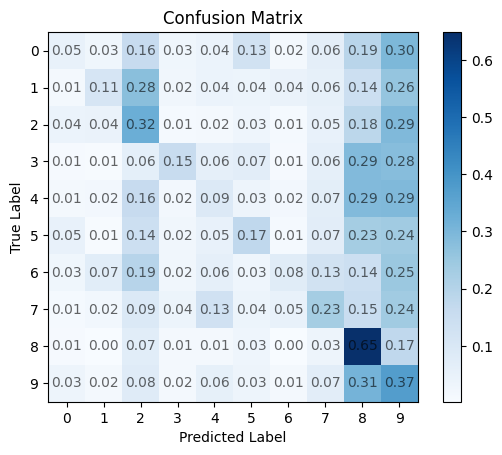

In [ ]:
y_pred_image = Self_attention_classifier_image.predict_testdataset(X_test_encoded)

# Accuracy
accuracy_val = accuracy(y_pred_image, Y_test)
print(f"The accuracy of the model is: {accuracy_val}")

# F1 Score
f1_score_val = f1_score(Y_test, y_pred_image)
print(f"The F1 score of the model is: {f1_score_val}")

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(Y_test,y_pred_image)
print("The confusion matrix heatmap is displayed below:")
confusion_matrix_heatmap(conf_matrix)

###### ***Saving:***

In [ ]:
# Save the model
save_model(Self_attention_classifier_image, '/content/drive/MyDrive/Colab Notebooks/E1 213 Pattern Recognition and Neural Network/Assignment_03/model_image.pkl')

###### ***Loading:***

In [ ]:
# Load the model
Self_attention_classifier_image = load_model('/content/drive/MyDrive/Colab Notebooks/E1 213 Pattern Recognition and Neural Network/Assignment_03/model_image.pkl')

In [ ]:
Self_attention_classifier_image.plot_losses()

In [ ]:
Self_attention_classifier_image.plot_accuracies()

In [ ]:
y_pred_image = Self_attention_classifier_image.predict_testdataset(X_test_encoded)

# Accuracy
accuracy_val = accuracy(y_pred_image, Y_test)
print(f"The accuracy of the model is: {accuracy_val}")

# F1 Score
f1_score_val = f1_score(Y_test, y_pred_image)
print(f"The F1 score of the model is: {f1_score_val}")

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(Y_test,y_pred_image)
print("The confusion matrix heatmap is displayed below:")
confusion_matrix_heatmap(conf_matrix)

###### **Results:**

| Patch Size | Accuracy | F1 Score |
|------------|----------|----------|
| 4          | 0.241    | 0.239    |
| 8          | 0.268    | 0.261    |
| 16         | 0.207    | 0.192    |


Patch Size 4:

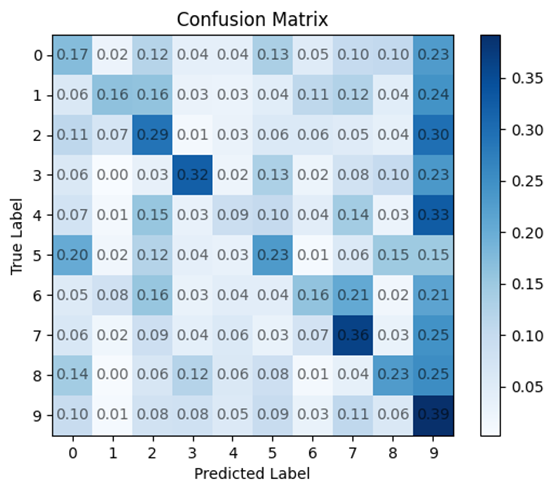

Patch Size 8:

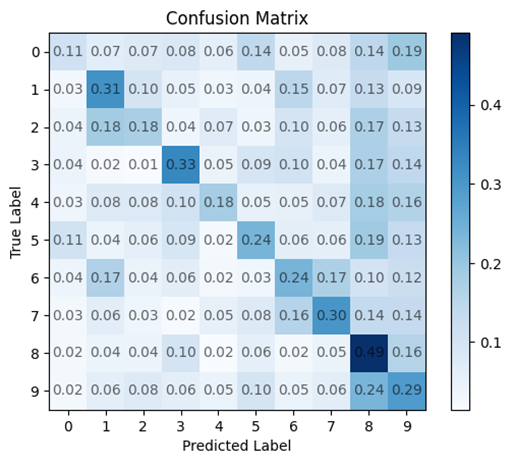

Patch Size 16:

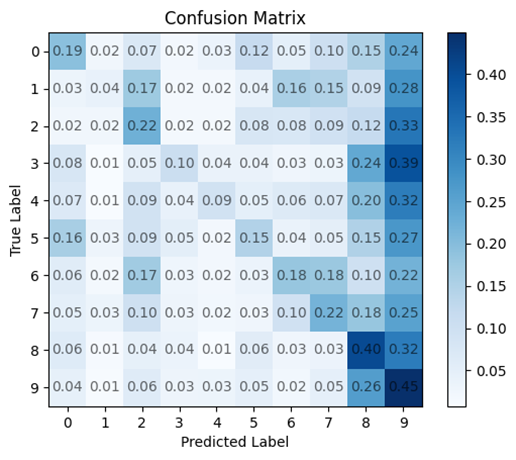

##### **On Text dataset (Tf-idf):**

###### ***Training:***

In [ ]:
Self_attention_classifier_text_tfidf = Model([
    self_attention_block(features = 1,emd_dim = 1, learning_rate = 0.005),
    reconfigure(),
    Dense(100,256, learning_rate = 0.005),
    LeakyReLU(),
    Dense(256,64, learning_rate = 0.005),
    LeakyReLU(),
    # Dense(512,64, learning_rate = 0.005),
    # LeakyReLU(),
    Dense(64,12, learning_rate = 0.005),
    softmax(12)
])

In [ ]:
Self_attention_classifier_text_tfidf.fit(train_x_text,train_y_text,validation_x_text,validation_y_text, batch_size = 5000, epochs=10, learning_rate = 0.0005,reg_strength=0.001)

###### ***Testing:***

In [ ]:
y_pred_tfidf = Self_attention_classifier_text_tfidf.predict_testdataset(test_x_text)

# Accuracy
accuracy_val = accuracy(y_pred_tfidf, test_y_text)
print(f"The accuracy of the model is: {accuracy_val}")

# F1 Score
f1_score_val = f1_score(test_y_text, y_pred_tfidf)
print(f"The F1 score of the model is: {f1_score_val}")


###### ***Saving:***

In [ ]:
# Save the model
save_model(Self_attention_classifier_text_tfidf, '/content/drive/MyDrive/Colab Notebooks/E1 213 Pattern Recognition and Neural Network/Assignment_03/model_text_tfidf.pkl')

###### ***Loading:***

In [ ]:
# Load the model
Self_attention_classifier_text_tfidf = load_model('/content/drive/MyDrive/Colab Notebooks/E1 213 Pattern Recognition and Neural Network/Assignment_03/model_text_tfidf.pkl')

In [ ]:
y_pred_tfidf = Self_attention_classifier_text_tfidf.predict_testdataset(test_x_text)

# Accuracy
accuracy_val = accuracy(y_pred_tfidf, test_y_text)
print(f"The accuracy of the model is: {accuracy_val}")

# F1 Score
f1_score_val = f1_score(test_y_text, y_pred_tfidf)
print(f"The F1 score of the model is: {f1_score_val}")

The accuracy of the model is: 0.08091694933800198
The F1 score of the model is: 0.012476590575492231


###### **Results:**



|     Token Size     |     Model Accuracy     |
|:------------------:|:----------------------:|
|          1         |        0.08808         |
|          2         |        0.10280         |
|          3         |        0.08338         |
|          4         |        0.10400         |



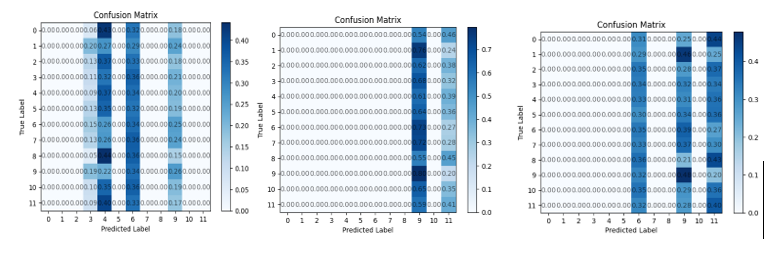

##### **On Text dataset (Word2Vec):**

###### ***Training:***

In [ ]:
Self_attention_classifier_text_word2vec = Model([
    self_attention_block(features = 1,emd_dim = 1, learning_rate = 0.0005),
    reconfigure(),
    Dense(100,256, learning_rate = 0.0005),
    LeakyReLU(),
    Dense(256,64, learning_rate = 0.0005),
    LeakyReLU(),
    # Dense(512,64, learning_rate = 0.0005),
    # LeakyReLU(),
    Dense(64,12, learning_rate = 0.0005),
    softmax(12)
])

In [ ]:
Self_attention_classifier_text_word2vec.fit(train_x_text,train_y_text,validation_x_text,validation_y_text, batch_size = 5000, epochs=10, learning_rate = 0.0005,reg_strength=0.001)

###### ***Testing:***

In [ ]:
y_pred_word2vec = Self_attention_classifier_text_word2vec.predict_testdataset(test_x_text)

# Accuracy
accuracy_val = accuracy(y_pred_word2vec, test_y_text)
print(f"The accuracy of the model is: {accuracy_val}")

# F1 Score
f1_score_val = f1_score(test_y_text, y_pred_word2vec)
print(f"The F1 score of the model is: {f1_score_val}")

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(test_y_text.to_numpy(),y_pred_word2vec)
print("The confusion matrix heatmap is displayed below:")
confusion_matrix_heatmap(conf_matrix)

###### ***Saving:***

In [ ]:
# Save the model
save_model(Self_attention_classifier_text_word2vec, '/content/drive/MyDrive/Colab Notebooks/E1 213 Pattern Recognition and Neural Network/Assignment_03/model_text_word2vec.pkl')

###### ***Loading:***

In [ ]:
# Load the model
Self_attention_classifier_text_word2vec = load_model('/content/drive/MyDrive/Colab Notebooks/E1 213 Pattern Recognition and Neural Network/Assignment_03/model_text_word2vec.pkl')

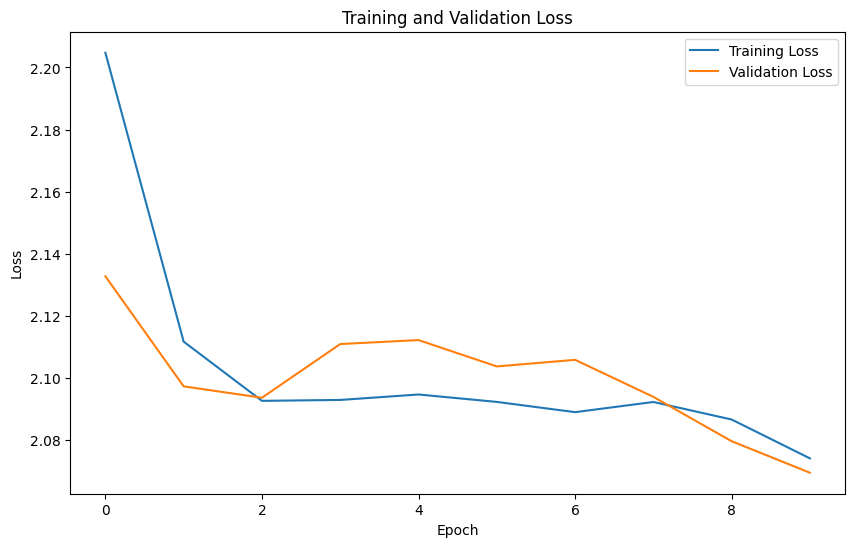

In [ ]:
Self_attention_classifier_text_word2vec.plot_losses()

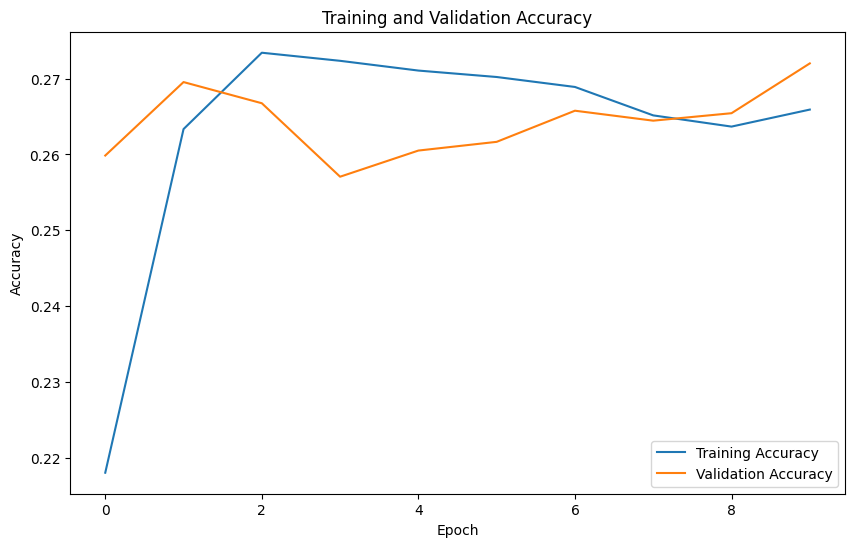

In [ ]:
Self_attention_classifier_text_word2vec.plot_accuracies()

The accuracy of the model is: 0.25588138746033484
The F1 score of the model is: 0.24417843082049198
The confusion matrix heatmap is displayed below:


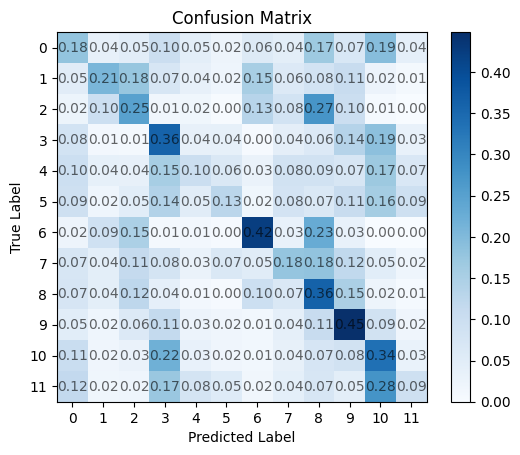

In [ ]:
y_pred_word2vec = Self_attention_classifier_text_word2vec.predict_testdataset(test_x_text)

# Accuracy
accuracy_val = accuracy(y_pred_word2vec, test_y_text)
print(f"The accuracy of the model is: {accuracy_val}")

# F1 Score
f1_score_val = f1_score(test_y_text, y_pred_word2vec)
print(f"The F1 score of the model is: {f1_score_val}")

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(test_y_text.to_numpy(),y_pred_word2vec)
print("The confusion matrix heatmap is displayed below:")
confusion_matrix_heatmap(conf_matrix)